In [1]:
from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.optimize import root_scalar as root

D:\Mark\Python\lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [11]:
def Omega(n,m,eta):
    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27
e3 = 642121496772645.10
e2 = 688358979309307.82
omega = 2.0*np.pi*1.0e6 #*650e3
m = 170.936331517*amutokg
eta = (2.*np.pi*e3/c)*np.sqrt(hbar/(2.*m*omega))
print(eta)
eta = 0.05

Ncut = 2001
omegas = np.zeros(Ncut)
#probs = np.zeros(Ncut)
#nbar = 10
for n in range(Ncut):
    omegas[n] = Omega(n,0,eta)
    #probs[n] = prob(n,nbar)

0.07317585153349442


D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_or

In [2]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27


def expE(nbar, omega, Ncut):
    expE = 0.0
    for n in range(Ncut):
        expE += prob(n,nbar)*hbar*omega*(0.5+n)
    return expE

def dopAndStark(n): #gives instantaneous doppler and stark shift in angular frequency units
    Ncut = 1201
    omega = 2.0*np.pi*650e3 #Our trap
    Omegarf = 2.0*np.pi*16.026e6 #Our trap
    m = 170.936331517*amutokg
    alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
    nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)
    return -2.0*np.pi*nu0*hbar*omega*(0.5+n)*(3.0/(m*c**2) + (alpha/(h*nu0))*(3.0*m*Omegarf**2/(2.0*e**2)))
#from Lange eqns 2.11 and 2.12

Ncut = 2001
dopAndStarks = np.zeros(Ncut)
ns = np.linspace(0,Ncut-1,Ncut)
for ii in range(Ncut):
    dopAndStarks[ii] = dopAndStark(ns[ii])

In [3]:
def rhoee(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,1]))**2.0
    return result

def rhogg(psi, nbar):
    Ncut = np.shape(psi)[0]
    result = 0.
    for n in range(Ncut):
        result += prob(n,nbar)*(abs(psi[n,0]))**2.0
    return result

def psi(g,e):
    return np.array([g, e])

def groundPsi(Ncut):
    result = np.zeros((Ncut,2),dtype="complex")
    result[:,0] = 1.
    return result

def subPulse(t, Omega0, delta, phi0, phi1):
    Omega = np.sqrt(Omega0**2 + delta**2)
    
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
        
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    
    V1 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(-1.0j*phi1)]])
    
    V0 = np.array([[1.0 , 0.0],
                   [0.0 , np.exp(1.0j*phi0)]])
    
    return np.exp(1.0j*delta*t/2.0)*V1@U@V0

def pulse(psi, t, Omega0, delta, phi0, phi1):
    Ncut = np.shape(psi)[0]
    result = np.zeros((Ncut,2),dtype="complex")
    if (Omega0==0):
        subpulse = subPulse(t, Omega0, delta, phi0, phi1)
        for n in range(Ncut):
            result[n,:] = subpulse@psi[n,:]
    else:
        for n in range(Ncut):
            result[n,:] = subPulse(t, Omega0*omegas[n], delta, phi0, phi1)@psi[n,:]
    return result

In [4]:
def HR(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    nbar0 = 0.
    delp1 = del1
    intState = subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        phi = (dopAndStarks[n]+dopAndStarks[0])*T/2.0
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0., deld, 0., phi)@intStateP
        psiM[n,:] = subPulse(t2, Omega0*omegas[n], delp2, 0.0, 0.0)@subPulse(T, 0., deld, 0., phi)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

def HRJump(deld, psi0, t1, T, t2, del1, del2, Omega0, nbarf, Ncut):
    delp1 = del1
    intState = subPulse(t1, Omega0, delp1, 0.0, 0.0)@psi0
    intStateP = subPulse(0.,0.,0.,0.,np.pi/2.)@intState 
    intStateM = subPulse(0.,0.,0.,0.,-np.pi/2.)@intState
    psiP = np.zeros((Ncut,2),dtype="complex")
    psiM = np.zeros((Ncut,2),dtype="complex")
    for n in range(Ncut):
        phi = (dopAndStarks[n]+dopAndStarks[0])*T/2.0
        delp2 = del2 + dopAndStarks[n] - dopAndStarks[0]
        psiP[n,:] = subPulse(t2/3.0,Omega0*omegas[n],delp2,0.0,0.0)@subPulse(2.0*t2/3.0,-Omega0*omegas[n],delp2,0.0,0.0)@subPulse(T, 0., deld, 0., phi)@intStateP
        psiM[n,:] = subPulse(t2/3.0,Omega0*omegas[n],delp2,0.0,0.0)@subPulse(2.0*t2/3.0,-Omega0*omegas[n],delp2,0.0,0.0)@subPulse(T, 0., deld, 0., phi)@intStateM
    return rhoee(psiP,nbarf)-rhoee(psiM,nbarf)

In [6]:
def shiftCurve(func, t1, T, t2, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -2.0
    x1 = 2.0
    guessTol = 5.0
    tol = 1e-6
    pts = np.size(nbarfs)
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

def shiftvDarkTime(func, t1, Ts, t2, delp1, delp2, Omega0, nbardot, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -2.0
    x1 = 2.0
    guessTol = 5.0
    tol = 1e-6
    pts = np.size(Ts)
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, Ts[ii], t2, delp1, delp2, Omega0, nbardot*Ts[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts


def shiftvOmega(func, t1, T, t2, delp1, delp2, Omegas, nbarf, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -9.0
    x1 = 9.0
    guessTol = 5.0
    tol = 1e-6
    pts = np.size(Omegas)
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1, T, t2, delp1, delp2, Omegas[ii], nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

def shiftvTimes(func, t1s, T, t2s, delp1, delp2, Omega0, nbarf, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -9.0
    x1 = 9.0
    guessTol = 5.0
    tol = 1e-6
    pts = np.size(t1s)
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t1s[ii], T, t2s[ii], delp1, delp2, Omega0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

def shiftCurve2(func, t, T, delp1, delp2, Omega0, nbarfs, Ncut):
    psi0 = psi(1.+0.j,0.+0.j)
    x0 = -0.1
    x1 = 0.1
    guessTol = 2.0
    tol = 1e-6
    shifts = np.zeros(pts)
    for ii in range(pts):
        shifts[ii] = root(func, args=(psi0, t, T, delp1, delp2, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root
        print(shifts[ii])
        x0 = shifts[ii] - guessTol
        x1 = shifts[ii] + guessTol
        print([x0,x1])
    return shifts

In [27]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.6,0.0, delPts)
nbarfPts = 10
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])

t1 = 22e-3
T = 150e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*24.0e-3)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HRJump, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
   

0.004754324538874189
[-4.995245675461126, 5.004754324538874]
0.00490431046191927
[-4.995095689538081, 5.004904310461919]
0.004929614829259785
[-4.99507038517074, 5.00492961482926]
0.004847242753318628
[-4.995152757246681, 5.004847242753319]
0.004672769689820154
[-4.9953272303101794, 5.0046727696898206]
0.004420855836943292
[-4.995579144163057, 5.004420855836943]
0.0041062170577605825
[-4.99589378294224, 5.00410621705776]
0.0037440853028293123
[-4.996255914697171, 5.003744085302829]
0.0033494825437592663
[-4.99665051745624, 5.00334948254376]
0.002936038264889266
[-4.997063961735111, 5.002936038264889]
0.003419009471033566
[-4.996580990528966, 5.003419009471034]
0.003325746313663155
[-4.996674253686336, 5.003325746313664]
0.0031235286569442507
[-4.996876471343056, 5.003123528656944]
0.0028284242236576176
[-4.997171575776342, 5.002828424223658]
0.00245512712902565
[-4.997544872870974, 5.002455127129026]
0.002017472060887374
[-4.997982527939112, 5.002017472060888]
0.0015295265851919806
[-4

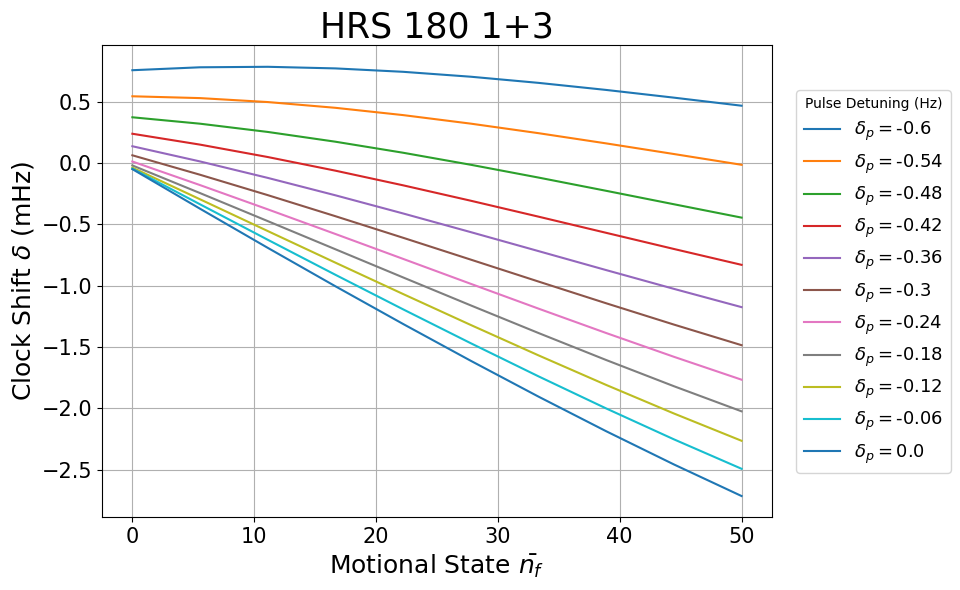

In [28]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("HRS 180 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [7]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.6,0.0, delPts)
Tpts = 10
Ts = np.linspace(20.0e-3, 300.0e-3, Tpts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*t1)
nbardot = 100.0
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftvDarkTime(HRJump, t1, Ts, t2, delPrimes[ii], delPrimes[ii], Omega0, nbardot, Ncut)

NameError: name 'psi' is not defined

In [ ]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(Ts*1e3, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title(r"HRS 180 1+3 (Constant $\dot{\bar{n}}$)",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Dark Time (ms)",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [81]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])


t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.013394351678476045
[-4.9866056483215235, 5.0133943516784765]
-0.002935295049486081
[-5.002935295049486, 4.997064704950514]
-0.019964509304497224
[-5.019964509304497, 4.980035490695503]
-0.03769083882025672
[-5.037690838820256, 4.962309161179744]
-0.05611188778394462
[-5.056111887783945, 4.943888112216055]
-0.07522539118689191
[-5.075225391186892, 4.924774608813108]
-0.09502927681106159
[-5.095029276811061, 4.904970723188939]
-0.11552171536924302
[-5.115521715369243, 4.884478284630757]
-0.13670115835754598
[-5.136701158357546, 4.863298841642454]
-0.1585663568145409
[-5.158566356814541, 4.841433643185459]
-0.1811163378957316
[-5.181116337895731, 4.818883662104269]
-0.20435029807907454
[-5.204350298079074, 4.795649701920926]
-0.228267372840528
[-5.228267372840528, 4.771732627159472]
-0.2528662722149904
[-5.25286627221499, 4.74713372778501]
-0.2781448146893512
[-5.278144814689351, 4.721855185310649]
-0.3040994243775004
[-5.3040994243775, 4.6959005756225]
-0.330724665210377
[-5.3307246652

-0.10774046296162319
[-5.107740462961623, 4.892259537038377]
-0.1145942877061162
[-5.114594287706116, 4.885405712293884]
-0.12158257055016779
[-5.121582570550168, 4.878417429449832]
-0.128702022397178
[-5.128702022397178, 4.871297977602822]
-0.13594907153414695
[-5.135949071534147, 4.864050928465853]
-0.14331992030145815
[-5.143319920301458, 4.856680079698542]
-0.15081060074986657
[-5.150810600749867, 4.849189399250133]
-0.1584170270489614
[-5.158417027048961, 4.841582972951039]
-0.16613504322274675
[-5.166135043222747, 4.833864956777253]
-0.17396046543808133
[-5.173960465438081, 4.826039534561919]
-0.00031194711639198104
[-5.000311947116392, 4.999688052883608]
-0.0009659324550113702
[-5.000965932455012, 4.999034067544988]
-0.0016282088655945957
[-5.001628208865594, 4.998371791134406]
-0.0022967219371228613
[-5.002296721937123, 4.997703278062877]
-0.0029696683843581807
[-5.002969668384358, 4.997030331615642]
-0.0036453613504642546
[-5.003645361350464, 4.996354638649536]
-0.004322235128

0.07481893540179567
[-4.925181064598204, 5.074818935401796]
0.09027929507410043
[-4.9097207049259, 5.0902792950741]
0.10630975649417031
[-4.89369024350583, 5.10630975649417]
0.12291247996172606
[-4.877087520038274, 5.122912479961726]
0.14008968561516022
[-4.85991031438484, 5.14008968561516]
0.15784357526443596
[-4.842156424735564, 5.157843575264436]
0.1761761527366005
[-4.8238238472634, 5.1761761527366]
0.1950889331326797
[-4.80491106686732, 5.19508893313268]
0.21458256727530736
[-4.785417432724692, 5.214582567275308]
0.23465643482854115
[-4.765343565171459, 5.234656434828541]
0.2553082670759893
[-4.744691732924011, 5.255308267075989]
0.27653384974088907
[-4.723466150259111, 5.276533849740889]
0.29832683592128695
[-4.701673164078713, 5.298326835921287]
0.32067867778808634
[-4.679321322211914, 5.320678677788086]
0.3435786686157358
[-4.656421331384264, 5.343578668615736]
0.36701407599579733
[-4.632985924004203, 5.367014075995797]
0.39097034236073036
[-4.60902965763927, 5.39097034236073]


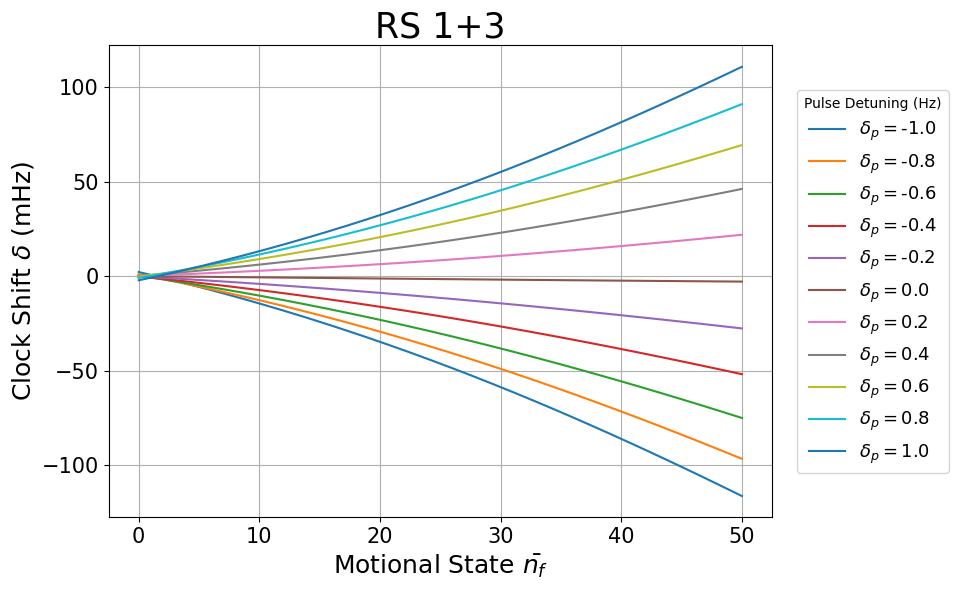

In [74]:

plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [83]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])


t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*22.0e-3)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.30621036470445345
[-4.693789635295547, 5.306210364704453]
0.2945865941918922
[-4.705413405808108, 5.294586594191892]
0.28235648705527744
[-4.717643512944723, 5.282356487055277]
0.26953310757273774
[-4.730466892427263, 5.269533107572737]
0.25612896002883717
[-4.743871039971163, 5.256128960028837]
0.24215595075777446
[-4.757844049242226, 5.242155950757774]
0.2276253635756851
[-4.772374636424315, 5.227625363575685]
0.21254784741575525
[-4.787452152584245, 5.212547847415755]
0.19693341589076394
[-4.803066584109236, 5.196933415890764]
0.1807914645005162
[-4.819208535499484, 5.180791464500516]
0.1641308260602713
[-4.835869173939729, 5.164130826060271]
0.14695990039796775
[-4.853040099602032, 5.146959900397968]
0.1292868911822687
[-4.870713108817731, 5.129286891182269]
0.111120153804916
[-4.888879846195084, 5.111120153804916]
0.09246861921445232
[-4.907531380785548, 5.092468619214452]
0.07334223169782071
[-4.92665776830218, 5.07334223169782]
0.05375233456019598
[-4.946247665439804, 5.053752

-0.015400500886842848
[-5.015400500886843, 4.984599499113157]
-0.020307139973928735
[-5.020307139973928, 4.979692860026072]
-0.025290995733635958
[-5.025290995733636, 4.974709004266364]
-0.030347980264942603
[-5.030347980264943, 4.969652019735057]
-0.03547382887948829
[-5.035473828879488, 4.964526171120512]
-0.04066415072555069
[-5.040664150725551, 4.959335849274449]
-0.045914479161900404
[-5.0459144791619, 4.9540855208381]
-0.05122031933584179
[-5.051220319335842, 4.948779680664158]
-0.05657719131132809
[-5.056577191311328, 4.943422808688672]
-0.06198066782400653
[-5.061980667824007, 4.938019332175993]
-0.06742640629907666
[-5.067426406299076, 4.932573593700924]
-0.00031194711639217945
[-5.000311947116392, 4.999688052883608]
-0.0009278189297907491
[-5.0009278189297905, 4.9990721810702095]
-0.0015596122832554358
[-5.0015596122832555, 4.9984403877167445]
-0.0022044031551156328
[-5.002204403155115, 4.997795596844885]
-0.0028595644423223734
[-5.002859564442322, 4.997140435557678]
-0.00352

-0.16389709567895952
[-5.163897095678959, 4.836102904321041]
-0.15205663748493678
[-5.152056637484937, 4.847943362515063]
-0.13978975277741162
[-5.1397897527774115, 4.8602102472225885]
-0.1271001804630264
[-5.127100180463026, 4.872899819536974]
-0.11399178002027598
[-5.113991780020276, 4.886008219979724]
-0.10046880024756792
[-5.100468800247568, 4.899531199752432]
-0.08653621034804072
[-5.086536210348041, 4.913463789651959]
-0.07220004280764113
[-5.0722000428076415, 4.9277999571923585]
-0.05746769398389046
[-5.057467693983891, 4.942532306016109]
-0.04234814078182249
[-5.042348140781822, 4.957651859218178]
-0.02685205178183036
[-5.02685205178183, 4.97314794821817]
-0.010991790780855472
[-5.010991790780856, 4.989008209219144]
0.005218674680899903
[-4.9947813253191, 5.0052186746809]
0.021763938928524476
[-4.978236061071476, 5.021763938928524]
0.03862737425240104
[-4.9613726257475985, 5.0386273742524015]
0.055791375007305744
[-4.944208624992695, 5.055791375007305]
0.07323761061857367
[-4.9

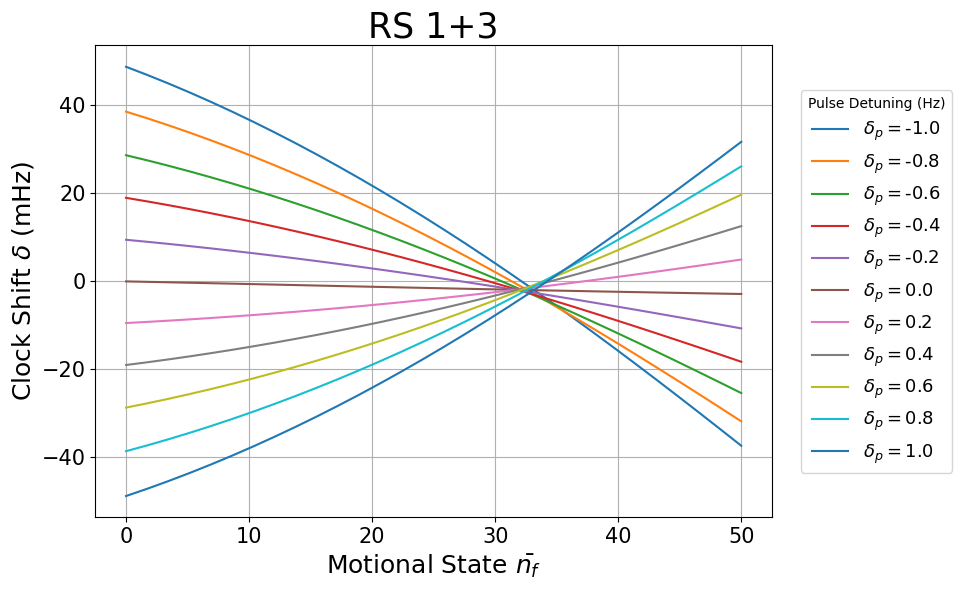

In [84]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [11]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])


t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*20.0e-3)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.5634220156246893
[-4.436577984375311, 5.563422015624689]
0.5544392348504309
[-4.445560765149569, 5.554439234850431]
0.5447346693747606
[-4.45526533062524, 5.54473466937476]
0.5343567814558694
[-4.46564321854413, 5.53435678145587]
0.5233479170202062
[-4.476652082979793, 5.523347917020207]
0.5117451942413486
[-4.488254805758651, 5.511745194241349]
0.499581244367536
[-4.500418755632464, 5.499581244367536]
0.48688483410595973
[-4.513115165894041, 5.486884834105959]
0.473681393532943
[-4.526318606467057, 5.473681393532943]
0.45999347590086637
[-4.540006524099134, 5.459993475900866]
0.44584118918822313
[-4.554158810811777, 5.445841189188223]
0.4312426523194728
[-4.568757347680528, 5.431242652319472]
0.4162145189230093
[-4.5837854810769905, 5.4162145189230095]
0.4007725729844655
[-4.599227427015535, 5.400772572984465]
0.38493235514246116
[-4.615067644857539, 5.384932355142461]
0.3687097513532705
[-4.63129024864673, 5.36870975135327]
0.3521214767114352
[-4.647878523288565, 5.352121476711435]

0.04307522861797281
[-4.9569247713820275, 5.0430752286179725]
0.038840888032416095
[-4.961159111967584, 5.038840888032416]
0.03456316142820433
[-4.9654368385717955, 5.0345631614282045]
0.030246846982517808
[-4.969753153017482, 5.030246846982518]
0.02589673262803852
[-4.974103267371961, 5.025896732628039]
0.021517550549325495
[-4.9784824494506745, 5.0215175505493255]
0.01711393604740654
[-4.982886063952593, 5.017113936047407]
0.012690392132234525
[-4.987309607867766, 5.012690392132234]
0.00825126042109944
[-4.991748739578901, 5.008251260421099]
0.0038006983626629183
[-4.996199301637337, 5.003800698362663]
-0.00031194711639388235
[-5.000311947116394, 4.999688052883606]
-0.000910696228346684
[-5.000910696228346, 4.999089303771654]
-0.0015446284129804618
[-5.00154462841298, 4.99845537158702]
-0.002207700422592203
[-5.002207700422592, 4.997792299577408]
-0.0028945572470111093
[-5.002894557247011, 4.997105442752989]
-0.0036003623211977344
[-5.0036003623211975, 4.9963996376788025]
-0.00432076

-0.3968040224441454
[-5.396804022444146, 4.603195977555854]
-0.3875181923598513
[-5.387518192359852, 4.612481807640148]
-0.3778482915908557
[-5.377848291590856, 4.622151708409144]
-0.36780520863375354
[-5.3678052086337535, 4.6321947913662465]
-0.35739887031334566
[-5.357398870313346, 4.642601129686654]
-0.3466386044236892
[-5.346638604423689, 4.653361395576311]
-0.33553356573890675
[-5.335533565738907, 4.664466434261093]
-0.3240931919284651
[-5.3240931919284655, 4.6759068080715345]
-0.31232763368399463
[-5.312327633683995, 4.687672366316005]
-0.30024810403519825
[-5.300248104035198, 4.699751895964802]
-0.2878671096113143
[-5.287867109611314, 4.712132890388686]
-0.2751985505647062
[-5.275198550564706, 4.724801449435294]
-0.2622576970962917
[-5.262257697096292, 4.737742302903708]
-0.24906106462527208
[-5.249061064625272, 4.750938935374728]
-0.2356262160960414
[-5.235626216096041, 4.764373783903959]
-0.22197152029399447
[-5.2219715202939945, 4.7780284797060055]
-0.20811589158420457
[-5.20

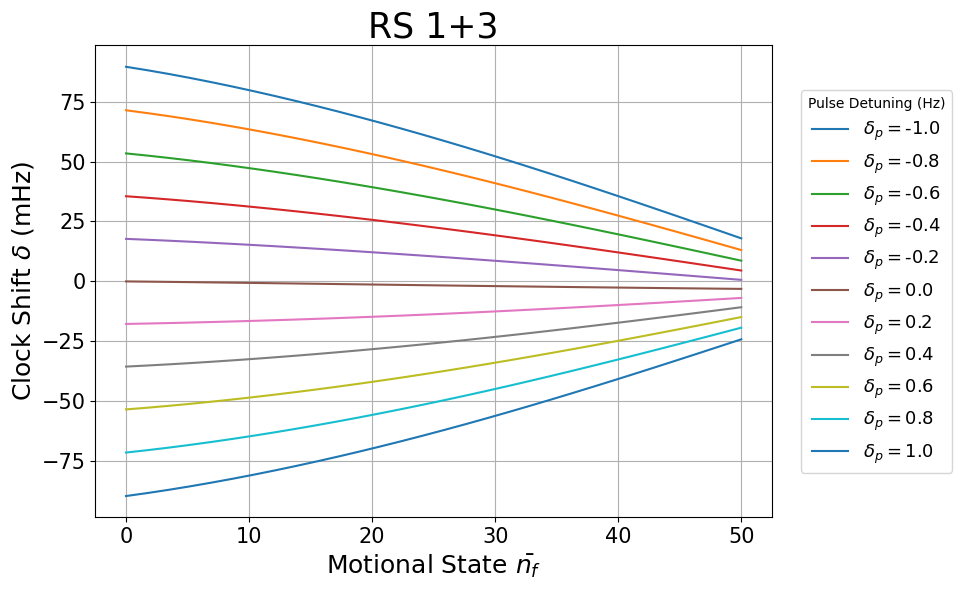

In [12]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [92]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])


t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*26.0e-3)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.3605307982998028
[-5.360530798299803, 4.639469201700197]
-0.3849193911195074
[-5.3849193911195075, 4.6150806088804925]
-0.4102837631124469
[-5.410283763112447, 4.589716236887553]
-0.436633951737605
[-5.436633951737605, 4.563366048262395]
-0.4639802663758739
[-5.463980266375874, 4.536019733624126]
-0.4923333674983868
[-5.492333367498387, 4.507666632501613]
-0.5217043350771494
[-5.52170433507715, 4.47829566492285]
-0.5521047264417746
[-5.552104726441774, 4.447895273558226]
-0.5835466224603808
[-5.583546622460381, 4.416453377539619]
-0.6160426528278141
[-5.616042652827814, 4.383957347172186]
-0.6496059701656117
[-5.649605970165612, 4.350394029834388]
-0.6842501178914898
[-5.68425011789149, 4.31574988210851]
-0.7199887349062413
[-5.7199887349062415, 4.2800112650937585]
-0.7568350750070126
[-5.756835075007013, 4.243164924992987]
-0.7948013737354426
[-5.794801373735442, 4.205198626264558]
-0.8338981401336931
[-5.833898140133693, 4.166101859866307]
-0.8741334673049437
[-5.874133467304944, 

-0.23011952288985477
[-5.230119522889855, 4.769880477110145]
-0.24073671075677225
[-5.240736710756773, 4.759263289243227]
-0.2516524940494711
[-5.2516524940494715, 4.7483475059505285]
-0.26286918916228164
[-5.262869189162282, 4.737130810837718]
-0.27438866159055014
[-5.27438866159055, 4.72561133840945]
-0.28621238419864775
[-5.286212384198648, 4.713787615801352]
-0.2983415019078962
[-5.298341501907896, 4.701658498092104]
-0.31077689842564116
[-5.310776898425641, 4.689223101574359]
-0.3235192617438236
[-5.323519261743824, 4.676480738256176]
-0.3365691461355672
[-5.3365691461355675, 4.6634308538644325]
-0.34992702921390534
[-5.349927029213905, 4.650072970786095]
-0.00031194711639290034
[-5.000311947116393, 4.999688052883607]
-0.0010247529792638958
[-5.001024752979264, 4.998975247020736]
-0.0017422930964051304
[-5.001742293096405, 4.998257706903595]
-0.002462957715002804
[-5.002462957715003, 4.997537042284997]
-0.0031853744560978382
[-5.0031853744560975, 4.9968146255439025]
-0.00390826958

0.47121317093774784
[-4.528786829062252, 5.471213170937748]
0.49673444833708924
[-4.503265551662911, 5.496734448337089]
0.5231727557014654
[-4.476827244298534, 5.523172755701466]
0.550543899702796
[-4.449456100297204, 5.550543899702796]
0.5788638449078983
[-4.421136155092102, 5.578863844907898]
0.6081483315853438
[-4.391851668414656, 5.608148331585344]
0.6384123635168505
[-4.36158763648315, 5.63841236351685]
0.6696696298480606
[-4.330330370151939, 5.669669629848061]
0.7019319392071798
[-4.29806806079282, 5.70193193920718]
0.7352087350407794
[-4.264791264959221, 5.735208735040779]
0.7695067378786707
[-4.230493262121329, 5.769506737878671]
0.8048297337280192
[-4.1951702662719805, 5.8048297337280195]
0.8411785053375281
[-4.1588214946624715, 5.8411785053375285]
0.8785508878356222
[-4.1214491121643775, 5.8785508878356225]
0.9169419223404985
[-4.083058077659501, 5.916941922340499]
0.9563440790840911
[-4.043655920915909, 5.956344079084091]
0.9967475234440981
[-4.003252476555902, 5.99674752344

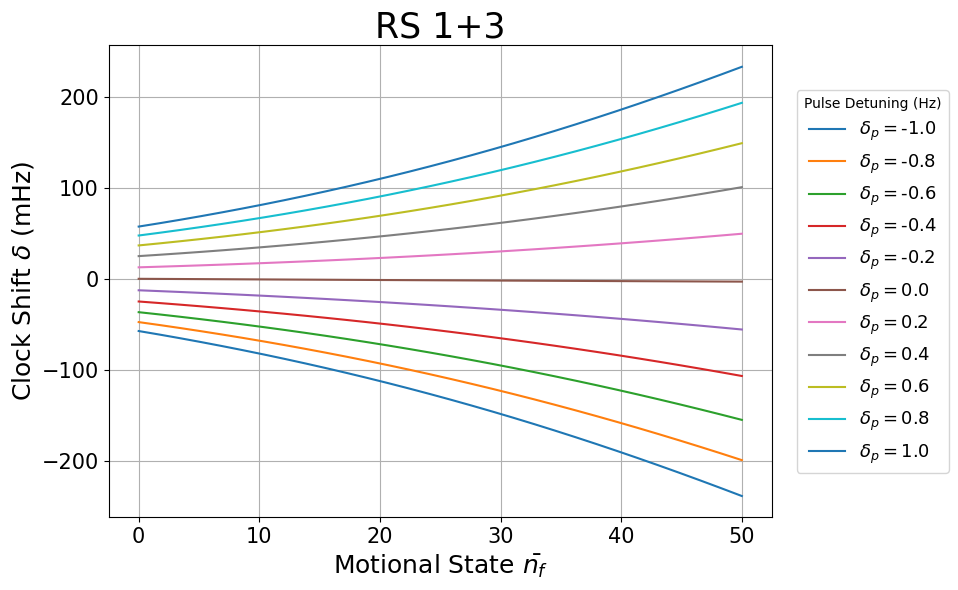

In [93]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 1+3",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [122]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])


t1 = 3.*24e-3
T = 150e-3
t2 = t1/3.
Omega0 = np.pi/(2.*t2)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.017342957091265668
[-4.982657042908734, 5.017342957091266]
0.015374187094991994
[-4.984625812905008, 5.015374187094992]
0.013441693071141108
[-4.986558306928859, 5.013441693071141]
0.01154484325902155
[-4.9884551567409785, 5.0115448432590215]
0.009683009486294917
[-4.990316990513705, 5.009683009486295]
0.0078555680657581
[-4.992144431934242, 5.007855568065758]
0.006061900604585058
[-4.9939380993954146, 5.0060619006045854]
0.004301394734386612
[-4.995698605265614, 5.004301394734386]
0.00257344481494062
[-4.99742655518506, 5.00257344481494]
0.0008774528941471886
[-4.999122547105853, 5.000877452894147]
-0.0007871692587533124
[-5.0007871692587536, 4.9992128307412464]
-0.0024209957545540993
[-5.002420995754554, 4.997579004245446]
-0.004024578837601836
[-5.004024578837602, 4.995975421162398]
-0.005598438056630069
[-5.00559843805663, 4.99440156194337]
-0.007143048072989001
[-5.007143048072989, 4.992856951927011]
-0.008658827621717097
[-5.008658827621717, 4.991341172378283]
-0.01014613196324

-0.012447995227314693
[-5.012447995227315, 4.987552004772685]
-0.013053966410685873
[-5.013053966410686, 4.986946033589314]
-0.01365158053013386
[-5.013651580530134, 4.986348419469866]
-0.014240618581927225
[-5.014240618581927, 4.985759381418073]
-0.014820857942883223
[-5.014820857942883, 4.985179142057117]
-0.015392079561827823
[-5.015392079561828, 4.984607920438172]
-0.015954074558154747
[-5.015954074558155, 4.984045925441845]
-0.016506649912826306
[-5.016506649912826, 4.983493350087174]
-0.017049633082654166
[-5.017049633082654, 4.982950366917346]
-0.01758287548607479
[-5.017582875486075, 4.982417124513925]
-0.0181062548953897
[-5.01810625489539, 4.98189374510461]
-0.01861967682765646
[-5.018619676827656, 4.981380323172344]
-0.00031194711639204116
[-5.000311947116392, 4.999688052883608]
-0.0007405565390650936
[-5.000740556539065, 4.999259443460935]
-0.0011700183599529159
[-5.001170018359953, 4.998829981640047]
-0.001599915200270606
[-5.001599915200271, 4.998400084799729]
-0.00202998

-0.00556698918063941
[-5.00556698918064, 4.99443301081936]
-0.00490434572634445
[-5.004904345726344, 4.995095654273656]
-0.004267247818860894
[-5.004267247818861, 4.995732752181139]
-0.0036548115613428823
[-5.003654811561343, 4.996345188438657]
-0.003066176672430686
[-5.003066176672431, 4.996933823327569]
-0.0025005064827013307
[-5.0025005064827015, 4.9974994935172985]
-0.001956987935931834
[-5.001956987935932, 4.998043012064068]
-0.0014348315832996522
[-5.0014348315833, 4.9985651684167]
-0.0009332714838512408
[-5.000933271483851, 4.999066728516149]
-0.00045156488779105394
[-5.000451564887791, 4.999548435112209]
1.100838985490434e-05
[-4.999988991610145, 5.000011008389855]
0.00045514691828810904
[-4.999544853081712, 5.000455146918288]
0.0008815288512333547
[-4.999118471148766, 5.000881528851234]
0.001290813251639702
[-4.998709186748361, 5.001290813251639]
0.001683641398563894
[-4.9983163586014365, 5.0016836413985635]
0.0020606379528448635
[-4.9979393620471555, 5.0020606379528445]
0.002

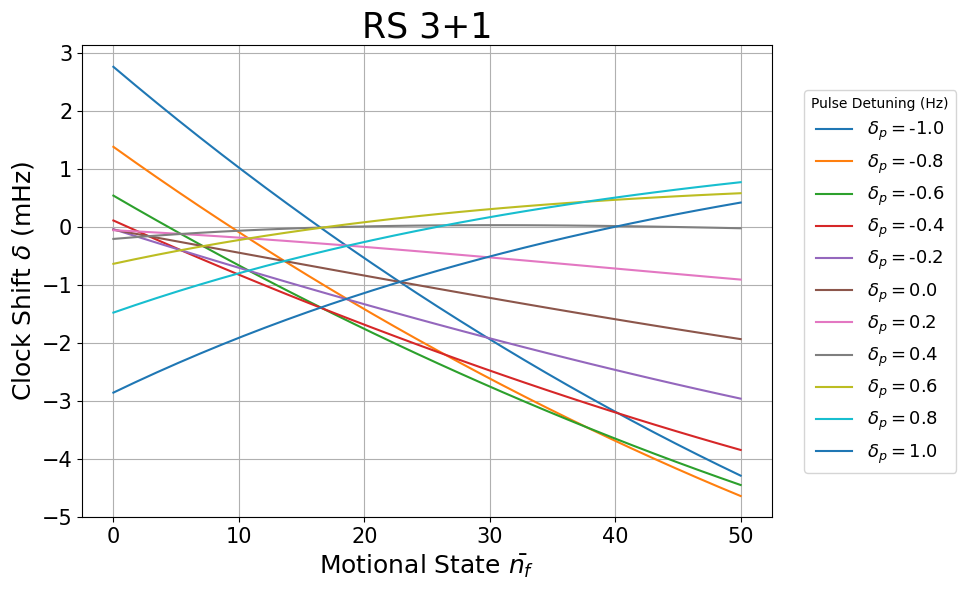

In [123]:

plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 3+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [124]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])


t1 = 3.*24e-3
T = 150e-3
t2 = t1/3.
Omega0 = np.pi/(2.*22.0e-3)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.30865862792992826
[-4.691341372070072, 5.308658627929928]
0.30615119537357377
[-4.693848804626426, 5.306151195373574]
0.3036938774905973
[-4.6963061225094025, 5.3036938774905975]
0.30128569615651335
[-4.698714303843486, 5.301285696156514]
0.2989256812291869
[-4.7010743187708135, 5.2989256812291865]
0.29661287192694513
[-4.703387128073055, 5.296612871926945]
0.29434631803127465
[-4.705653681968725, 5.294346318031275]
0.2921250809566127
[-4.7078749190433875, 5.2921250809566125]
0.2899482347561596
[-4.710051765243841, 5.289948234756159]
0.2878148674184997
[-4.7121851325815, 5.2878148674185]
0.28572408347330963
[-4.714275916526691, 5.285724083473309]
0.2836750095024869
[-4.7163249904975135, 5.2836750095024865]
0.2816668037487135
[-4.718333196251287, 5.281666803748713]
0.2796986694496642
[-4.720301330550336, 5.279698669449664]
0.27776986972931716
[-4.722230130270683, 5.277769869729317]
0.2758797409230539
[-4.724120259076946, 5.275879740923054]
0.2740277014711386
[-4.725972298528862, 5.274

0.03953356993992286
[-4.960466430060077, 5.039533569939923]
0.038963056029896345
[-4.961036943970104, 5.038963056029896]
-0.00031194711639269266
[-5.000311947116392, 4.999688052883608]
-0.0007351735917470155
[-5.000735173591747, 4.999264826408253]
-0.001160434870822517
[-5.0011604348708225, 4.9988395651291775]
-0.0015872411705769196
[-5.001587241170577, 4.998412758829423]
-0.0020152588519772984
[-5.002015258851977, 4.997984741148023]
-0.0024441677060006196
[-5.002444167706001, 4.997555832293999]
-0.002873660796418413
[-5.002873660796419, 4.997126339203581]
-0.003303444253255849
[-5.003303444253256, 4.996696555746744]
-0.0037332370030411007
[-5.003733237003041, 4.996266762996959]
-0.0041627703168248915
[-5.0041627703168245, 4.9958372296831755]
-0.0045917868120278664
[-5.0045917868120275, 4.9954082131879725]
-0.005020038315803264
[-5.005020038315803, 4.994979961684197]
-0.005447282118300191
[-5.0054472821183005, 4.9945527178816995]
-0.005873275700820486
[-5.005873275700821, 4.99412672429

-0.23004471787071515
[-5.230044717870715, 4.769955282129285]
-0.22931890105917263
[-5.229318901059172, 4.770681098940828]
-0.22861900306524613
[-5.228619003065246, 4.771380996934754]
-0.22794413284185536
[-5.227944132841856, 4.772055867158144]
-0.22729343082113143
[-5.227293430821131, 4.772706569178869]
-0.22666606600831454
[-5.226666066008314, 4.773333933991686]
-0.22606123311912307
[-5.226061233119123, 4.773938766880877]
-0.22547814998136792
[-5.225478149981368, 4.774521850018632]
-0.22491605534213385
[-5.224916055342134, 4.775083944657866]
-0.22437420714640524
[-5.224374207146405, 4.775625792853595]
-0.2238518812922933
[-5.223851881292293, 4.776148118707707]
-0.22334837082424988
[-5.22334837082425, 4.77665162917575]
-0.22286298549975214
[-5.222862985499752, 4.777137014500248]
-0.22239505165243148
[-5.222395051652431, 4.777604948347569]
-0.22194391227321256
[-5.221943912273213, 4.778056087726787]
-0.30928223693868956
[-5.30928223693869, 4.69071776306131]
-0.3076219155943659
[-5.30762

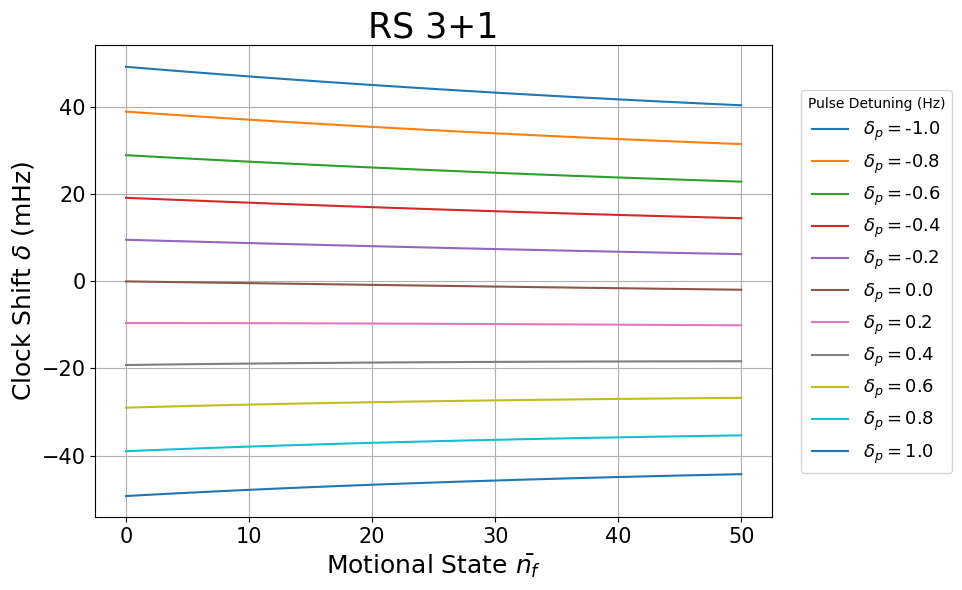

In [125]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 3+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [13]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])


t1 = 3.*24e-3
T = 150e-3
t2 = t1/3.
Omega0 = np.pi/(2.*26.0e-3)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.3542078965357521
[-5.354207896535752, 4.645792103464248]
-0.35583421110693164
[-5.355834211106932, 4.644165788893068]
-0.35743246419235497
[-5.357432464192355, 4.642567535807645]
-0.35900310134460284
[-5.3590031013446024, 4.6409968986553976]
-0.36054656613714686
[-5.360546566137147, 4.639453433862853]
-0.36206329958524947
[-5.362063299585249, 4.637936700414751]
-0.36355373958189224
[-5.363553739581892, 4.636446260418108]
-0.36501832038437293
[-5.365018320384373, 4.634981679615627]
-0.36645747210887786
[-5.366457472108878, 4.633542527891122]
-0.3678716199954803
[-5.36787161999548, 4.63212838000452]
-0.36926118275565334
[-5.369261182755653, 4.630738817244347]
-0.3706265689066003
[-5.370626568906601, 4.629373431093399]
-0.37196817024838424
[-5.371968170248384, 4.628031829751616]
-0.37328635268609206
[-5.373286352686092, 4.626713647313908]
-0.37458144583277153
[-5.374581445832772, 4.625418554167228]
-0.3758537335165392
[-5.375853733516539, 4.624146266483461]
-0.37710344718503225
[-5.377

-0.09302442776712853
[-5.093024427767128, 4.906975572232872]
-0.09352617259128083
[-5.093526172591281, 4.906473827408719]
-0.09401918547964035
[-5.09401918547964, 4.90598081452036]
-0.0945033407350269
[-5.094503340735027, 4.905496659264973]
-0.0949785380647524
[-5.094978538064752, 4.905021461935248]
-0.0003119471163932566
[-5.000311947116393, 4.999688052883607]
-0.0007442893272377495
[-5.000744289327238, 4.999255710672762]
-0.0011766512119453048
[-5.001176651211945, 4.998823348788055]
-0.0016086655476423783
[-5.001608665547642, 4.998391334452358]
-0.0020401168298590277
[-5.002040116829859, 4.997959883170141]
-0.0024707984969822923
[-5.002470798496982, 4.997529201503018]
-0.002900512745603555
[-5.002900512745604, 4.997099487254396]
-0.003329070326763835
[-5.003329070326764, 4.996670929673236]
-0.0037562903077167113
[-5.003756290307717, 4.996243709692283]
-0.004181999692308157
[-5.0041819996923085, 4.9958180003076915]
-0.004606032578104318
[-5.0046060325781045, 4.9953939674218955]
-0.005

0.29921545465433
[-4.70078454534567, 5.29921545465433]
0.29946428675456904
[-4.700535713245431, 5.299464286754569]
0.2997009728576374
[-4.700299027142362, 5.299700972857638]
0.2999260246554655
[-4.700073975344535, 5.299926024655465]
0.3001399444034793
[-4.69986005559652, 5.30013994440348]
0.30034322468697205
[-4.699656775313028, 5.300343224686972]
0.3005363479047958
[-4.699463652095204, 5.300536347904796]
0.30071978555481854
[-4.6992802144451815, 5.3007197855548185]
0.30089399740756195
[-4.699106002592438, 5.300893997407562]
0.30105943064617885
[-4.698940569353821, 5.301059430646179]
0.30121651903788293
[-4.698783480962117, 5.301216519037883]
0.3013656821861697
[-4.698634317813831, 5.301365682186169]
0.3015073248983848
[-4.698492675101615, 5.301507324898385]
0.30164183668911115
[-4.698358163310889, 5.301641836689111]
0.3535842875270151
[-4.646415712472985, 5.353584287527015]
0.35434544197462553
[-4.645654558025375, 5.354345441974625]
0.3550788088512878
[-4.644921191148712, 5.3550788088

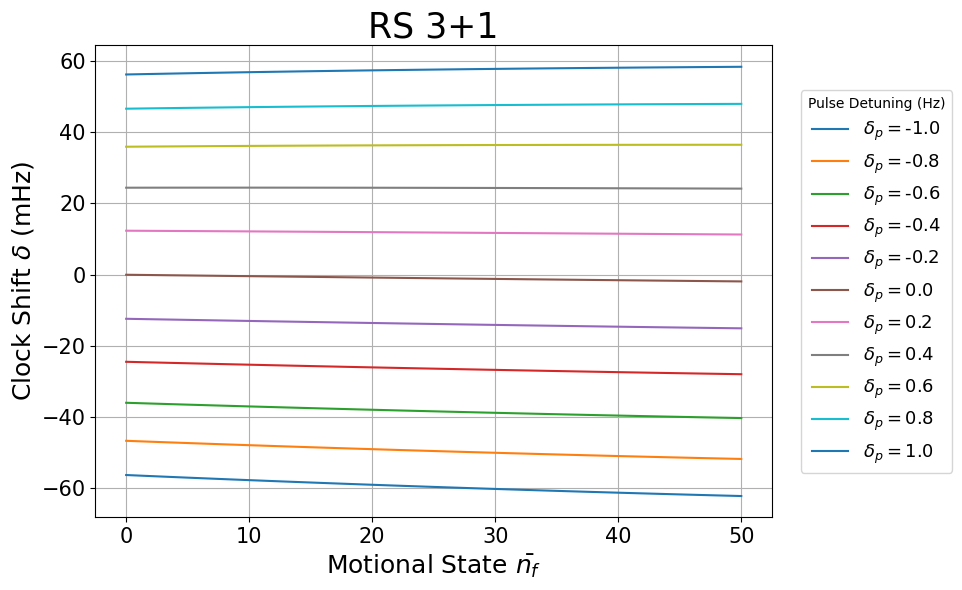

In [14]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 3+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [9]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.05,0.05, delPts)
Tpts = 10
Ts = np.linspace(20.0e-3, 300.0e-3, Tpts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.*t1)
nbardot = 100.0
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftvDarkTime(HR, t1, Ts, t2, delPrimes[ii], delPrimes[ii], Omega0, nbardot, Ncut)

NameError: name 'psi' is not defined

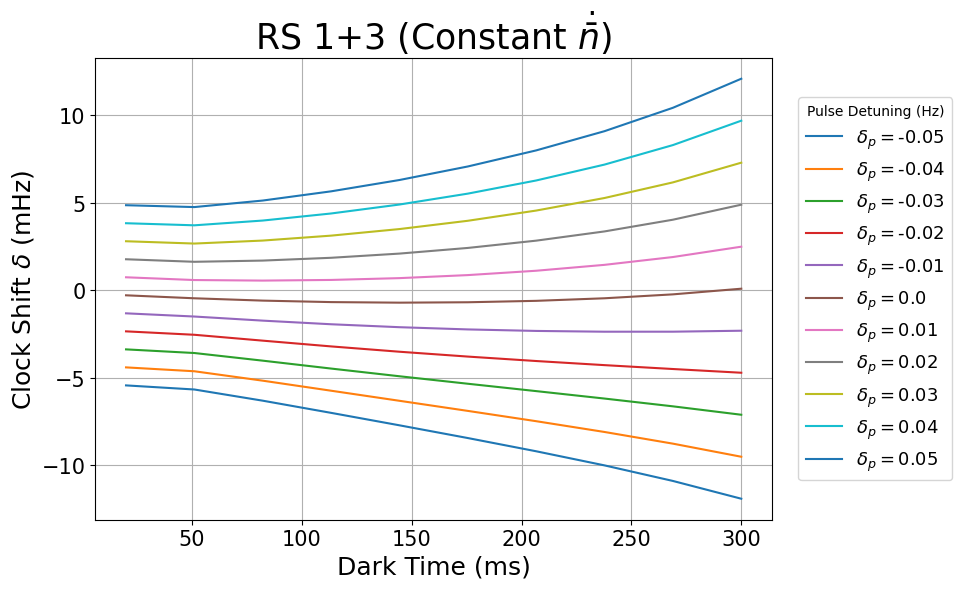

In [24]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(Ts*1e3, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title(r"RS 1+3 (Constant $\dot{\bar{n}}$)",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Dark Time (ms)",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [86]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])


t1 = 24e-3
T = 150e-3
t2 = t1
Omega0 = np.pi/(2.*t1)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

1.2786694294239562
[-3.7213305705760438, 6.278669429423957]
1.2767006595155825
[-3.7232993404844175, 6.2767006595155825]
1.2747681654917327
[-3.7252318345082673, 6.274768165491732]
1.2728713156796116
[-3.7271286843203884, 6.272871315679612]
1.27100948190689
[-3.72899051809311, 6.27100948190689]
1.2691820404863476
[-3.7308179595136526, 6.269182040486347]
1.2673883730251736
[-3.732611626974826, 6.267388373025174]
1.2656278671549799
[-3.73437213284502, 6.26562786715498]
1.2638999172355296
[-3.7361000827644704, 6.26389991723553]
1.2622039253147457
[-3.7377960746852543, 6.262203925314745]
1.2605393031618435
[-3.7394606968381563, 6.260539303161844]
1.2589054766660444
[-3.7410945233339556, 6.258905476666044]
1.2573018935829932
[-3.7426981064170066, 6.257301893582993]
1.2557280343639707
[-3.7442719656360293, 6.255728034363971]
1.2541834243476042
[-3.7458165756523956, 6.254183424347604]
1.2526676447988838
[-3.747332355201116, 6.252667644798883]
1.251180340457346
[-3.748819659542654, 6.251180340

0.23879774295119655
[-4.7612022570488035, 5.2387977429511965]
0.23826450054777157
[-4.761735499452229, 5.238264500547771]
0.23774112113845727
[-4.762258878861543, 5.237741121138457]
0.2372276992061914
[-4.7627723007938085, 5.2372276992061915]
-0.00031194711639195594
[-5.000311947116392, 4.999688052883608]
-0.0007405565390650393
[-5.000740556539065, 4.999259443460935]
-0.0011700183599521626
[-5.001170018359952, 4.998829981640048]
-0.001599915200271106
[-5.001599915200271, 4.998400084799729]
-0.0020299832150515707
[-5.002029983215052, 4.997970016784948]
-0.0024599693364627142
[-5.002459969336463, 4.997540030663537]
-0.002889631095133829
[-5.002889631095134, 4.997110368904866]
-0.0033187364112222673
[-5.003318736411222, 4.996681263588778]
-0.003747063340137598
[-5.003747063340137, 4.996252936659863]
-0.004174399661023378
[-5.004174399661023, 4.995825600338977]
-0.004600541968524207
[-5.004600541968524, 4.995399458031476]
-0.005025293714709918
[-5.00502529371471, 4.99497470628529]
-0.00544

-1.0115932537276535
[-6.0115932537276535, 3.9884067462723465]
-1.0112601576964293
[-6.011260157696429, 3.9887398423035707]
-1.0109405460302152
[-6.010940546030215, 3.9890594539697846]
-1.010633868319911
[-6.0106338683199105, 3.989366131680089]
-1.0103395888483733
[-6.010339588848373, 3.9896604111516267]
-1.0100571868750814
[-6.010057186875081, 3.9899428131249186]
-1.0097861569638162
[-6.009786156963816, 3.9902138430361838]
-1.0095260093116394
[-6.00952600931164, 3.9904739906883604]
-1.2792930384330663
[-6.2792930384330665, 3.7207069615669335]
-1.2781820305911475
[-6.2781820305911475, 3.7218179694088525]
-1.2771086791369066
[-6.277108679136907, 3.722891320863093]
-1.2760718057285807
[-6.276071805728581, 3.7239281942714193]
-1.2750702571960453
[-6.275070257196045, 3.7249297428039547]
-1.2741029062443652
[-6.274102906244365, 3.725897093755635]
-1.2731686519142071
[-6.273168651914207, 3.726831348085793]
-1.2722664199022644
[-6.272266419902264, 3.727733580097736]
-1.2713951627642763
[-6.271

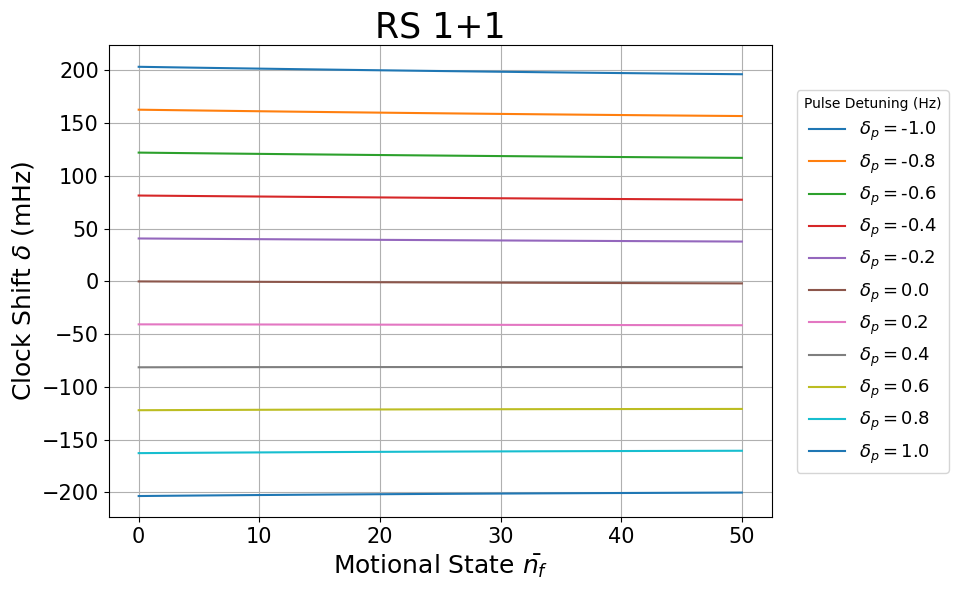

In [87]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 1+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [88]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results = np.zeros([delPts, nbarfPts])


t1 = 24e-3
T = 150e-3
t2 = t1
Omega0 = np.pi/(2.*22.0e-3)
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

1.3523521863994554
[-3.6476478136005444, 6.352352186399456]
1.3498447538780713
[-3.650155246121929, 6.349844753878071]
1.347387435995092
[-3.652612564004908, 6.347387435995092]
1.3449792546610062
[-3.6550207453389936, 6.344979254661006]
1.34261923973368
[-3.65738076026632, 6.34261923973368]
1.3403064304314416
[-3.6596935695685584, 6.340306430431442]
1.338039876535773
[-3.661960123464227, 6.338039876535773]
1.335818639461127
[-3.6641813605388727, 6.335818639461127]
1.3336417932606532
[-3.6663582067393468, 6.333641793260654]
1.3315084259229986
[-3.6684915740770014, 6.331508425922999]
1.3294176419777997
[-3.6705823580222003, 6.3294176419778]
1.327368568006977
[-3.672631431993023, 6.3273685680069764]
1.3253603622532053
[-3.674639637746795, 6.325360362253205]
1.3233922279541663
[-3.6766077720458337, 6.323392227954166]
1.321463428233823
[-3.678536571766177, 6.321463428233823]
1.31957329942755
[-3.68042670057245, 6.3195732994275495]
1.3177212599756436
[-3.6822787400243566, 6.317721259975643]


-0.0007351735917447295
[-5.000735173591745, 4.999264826408255]
-0.0011604348708238368
[-5.001160434870823, 4.998839565129177]
-0.001587241170579368
[-5.001587241170579, 4.998412758829421]
-0.0020152588519775382
[-5.002015258851977, 4.997984741148023]
-0.0024441677060144614
[-5.002444167706014, 4.997555832293986]
-0.002873660796422522
[-5.002873660796422, 4.997126339203578]
-0.0033034442532585183
[-5.003303444253259, 4.996696555746741]
-0.003733237003044532
[-5.003733237003044, 4.996266762996956]
-0.004162770316821537
[-5.004162770316822, 4.995837229683178]
-0.004591786812034738
[-5.004591786812035, 4.995408213187965]
-0.005020038315794643
[-5.005020038315795, 4.994979961684205]
-0.0054472821183007315
[-5.0054472821183005, 4.9945527178816995]
-0.005873275700825992
[-5.005873275700826, 4.994126724299174]
-0.00629777069699855
[-5.006297770696999, 4.993702229303001]
-0.006720507240123202
[-5.006720507240123, 4.993279492759877]
-0.007141209805148925
[-5.007141209805149, 4.992858790194851]
-

-1.0607829478449446
[-6.060782947844944, 3.9392170521550556]
-1.0603150139976252
[-6.060315013997625, 3.9396849860023746]
-1.059863874618401
[-6.059863874618401, 3.940136125381599]
-1.3529757954085522
[-6.352975795408552, 3.647024204591448]
-1.3513154740988629
[-6.351315474098863, 3.648684525901137]
-1.3497089931580046
[-6.349708993158004, 3.6502910068419956]
-1.3481546847130947
[-6.348154684713094, 3.6518453152869053]
-1.3466509156088184
[-6.346650915608818, 3.6533490843911816]
-1.3451960886322167
[-6.345196088632217, 3.6548039113677833]
-1.3437886434161517
[-6.3437886434161515, 3.6562113565838485]
-1.342427057111266
[-6.342427057111266, 3.6575729428887342]
-1.3411098448664773
[-6.3411098448664776, 3.6588901551335224]
-1.3398355602360577
[-6.339835560236057, 3.6601644397639426]
-1.3386027958039968
[-6.338602795803997, 3.6613972041960032]
-1.3374101844388557
[-6.3374101844388555, 3.6625898155611445]
-1.3362564014292522
[-6.336256401429252, 3.663743598570748]
-1.335140167296819
[-6.3351

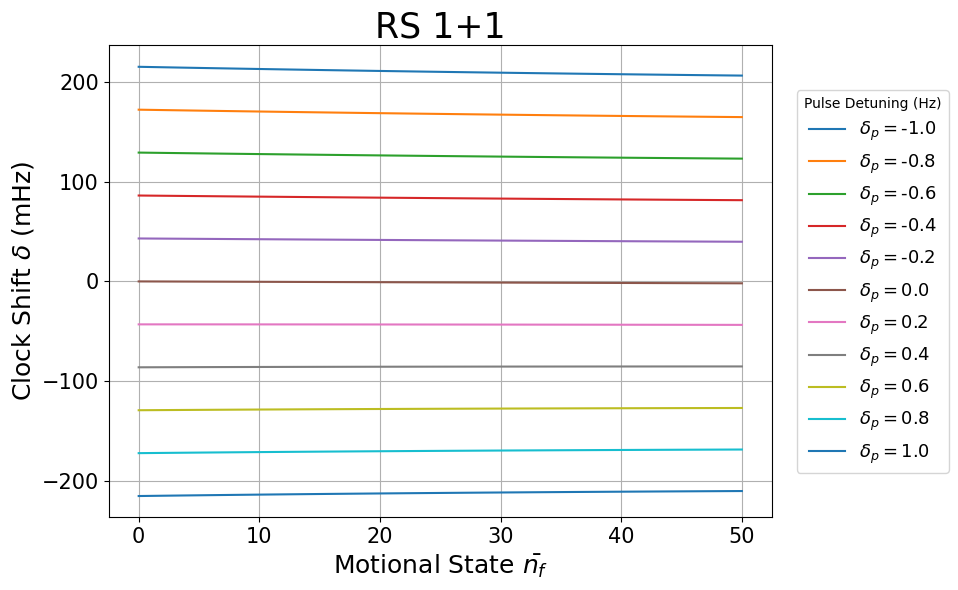

In [89]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 1+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [26]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-0.05,0.05,delPts)
Tpts = 10
Ts = np.linspace(20.0e-3, 300.0e-3, Tpts)
results = np.zeros([delPts, nbarfPts])

t1 = 20e-3
t2 = t1
Omega0 = np.pi/(2.*t1)
nbardot = 100.0
Ncut = 300

for ii in range(delPts):
    results[ii,:] = shiftvDarkTime(HR, t1, Ts, t2, delPrimes[ii], delPrimes[ii], Omega0, nbardot, Ncut)

0.39718166785798764
[-4.602818332142013, 5.397181667857987]
0.1533080793949864
[-4.846691920605013, 5.153308079394987]
0.09344336180279013
[-4.90655663819721, 5.09344336180279]
0.06607825759108543
[-4.933921742408915, 5.066078257591085]
0.05024237536398702
[-4.949757624636013, 5.050242375363987]
0.039832757681410355
[-4.960167242318589, 5.039832757681411]
0.03241968909771544
[-4.967580310902284, 5.032419689097716]
0.026841205868243925
[-4.973158794131756, 5.026841205868244]
0.02246877548601579
[-4.977531224513984, 5.022468775486016]
0.018930889010009014
[-4.981069110989991, 5.018930889010009]
0.3177148062341093
[-4.682285193765891, 5.317714806234109]
0.12243389722829315
[-4.8775661027717065, 5.1224338972282935]
0.07436720936237964
[-4.9256327906376205, 5.0743672093623795]
0.052309699342398014
[-4.947690300657602, 5.052309699342398]
0.039486572996861646
[-4.960513427003138, 5.039486572996862]
0.031016127969494628
[-4.968983872030505, 5.031016127969495]
0.024954359083269255
[-4.975045640

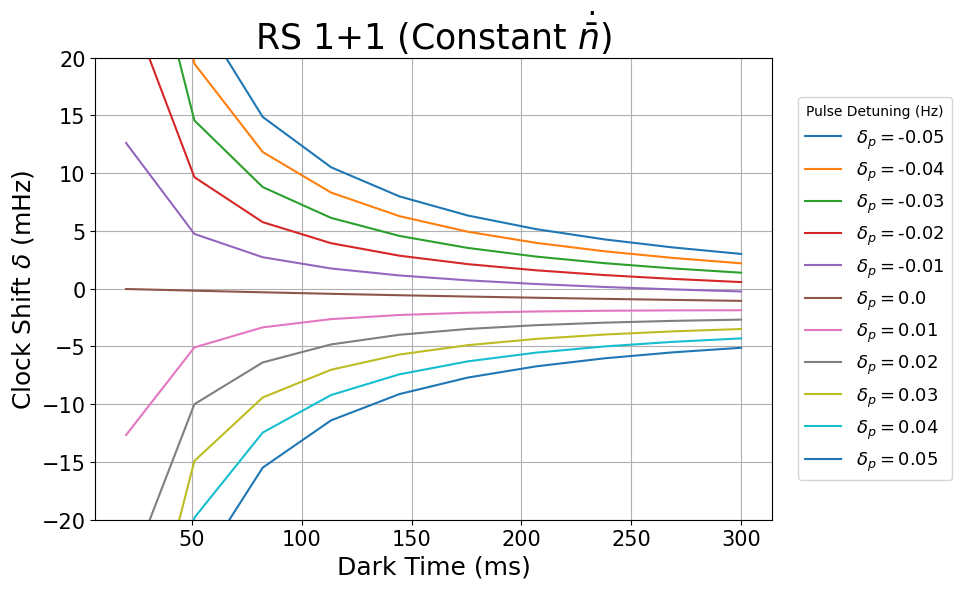

In [27]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(Ts*1e3, 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title(r"RS 1+1 (Constant $\dot{\bar{n}}$)",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Dark Time (ms)",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.ylim(-20,20)
plt.show()

In [29]:
(8+7.5)*10

155.0

In [31]:
4/0.6

6.666666666666667

In [42]:
psi0 = psi(1.+0.j,0.+0.j)

x0 = -10.0
x1 = 10
tol = 1e-6
t1 = 20.0e-3
T = 150.0e-3
t2 = t1
Omega0 = np.pi/(2.*23.0e-3)
nbardot = 100.
nbarf = (t1+T+t2)*nbardot
Ncut = 2000
delp1 = -2.0*np.pi*2.0
delp2 = delp1
    
root(HR, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root/(2.0*np.pi)


0.3163221174507336

In [77]:
pts = 6
#delps = 2.0*np.pi*np.linspace(-2,2,pts)
delp1 = -1.0*np.pi*2.0
shifts1 = np.zeros(pts)
shifts2 = np.zeros(pts)
shifts3 = np.zeros(pts)
shifts4 = np.zeros(pts)

psi0 = psi(1.+0.j,0.+0.j)

x0 = -6.0
x1 = 6.0

tol = 1e-6
t1 = 24.0e-3
T = 150.0e-3
#t2 = t1*3.
Omega0 = np.pi/(2.*t1)
Omega0b = np.pi/(2.*22.)
nbarfs = np.linspace(0,200,pts)
Ncut = 1000

#root(HR, args=(psi0, t1, T, t2, delp1, delp2, Omega0, nbarf, Ncut), bracket=[x0,x1], xtol = tol).root/(2.0*np.pi)
for ii in range(pts):
    shifts1[ii] =root(HR, args=(psi0, t1, T, t1, delp1, delp1, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root/(2.0*np.pi)
    shifts2[ii] =root(HR, args=(psi0, t1, T, 3.*t2, delp1, delp1, Omega0, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root/(2.0*np.pi)
    shifts3[ii] =root(HR, args=(psi0, t1, T, t1, delp1, delp1, Omega0b, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root/(2.0*np.pi)
    shifts4[ii] =root(HR, args=(psi0, t1, T, 3.*t2, delp1, delp1, Omega0b, nbarfs[ii], Ncut), bracket=[x0,x1], xtol = tol).root/(2.0*np.pi)

ValueError: f(a) and f(b) must have different signs

In [ ]:
plt.figure(figsize=(10,6), dpi=100)
plt.plot(nbarfs, shifts1)
plt.plot(nbarfs, shifts2)
plt.plot(nbarfs, shifts3)
plt.plot(nbarfs, shifts4)
#plt.plot(nbarfs, shifts3+shifts4)

In [49]:
2*2/(np.pi/(2*24e-3)*150e-3)

0.40743665431525206

In [77]:
t1+T+t2

0.22999999999999998

In [67]:
np.sqrt(3.*0.01**2)

0.017320508075688773

In [82]:
hbar*19e6/(2.*1.38e-23)

7.259733527274266e-05

In [9]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
OmegaPts = 30
Omegas = np.linspace(0.9, 1.1, OmegaPts)*np.pi/(2.*24.0e-3)
results = np.zeros([delPts, OmegaPts])


t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*24.0e-3)
Ncut = 300
nbarf = 35

for ii in range(delPts):
    results[ii,:] = shiftvOmega(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omegas, nbarf, Ncut)

-1.3317425126560594
[-6.331742512656059, 3.668257487343941]
-1.2443643193270963
[-6.244364319327096, 3.7556356806729037]
-1.1625091879661107
[-6.16250918796611, 3.8374908120338893]
-1.0856782621724976
[-6.085678262172498, 3.9143217378275024]
-1.0134280922475634
[-6.013428092247564, 3.9865719077524364]
-0.9453634777208195
[-5.94536347772082, 4.05463652227918]
-0.8811313809813522
[-5.881131380981352, 4.118868619018648]
-0.8204156889987273
[-5.820415688998727, 4.179584311001273]
-0.762932698753007
[-5.762932698753007, 4.237067301246993]
-0.708427220036115
[-5.708427220036115, 4.291572779963885]
-0.656669205088288
[-5.656669205088288, 4.343330794911712]
-0.6074508281840517
[-5.607450828184052, 4.392549171815948]
-0.5605839499658947
[-5.560583949965895, 4.439416050034105]
-0.5158979112645264
[-5.515897911264527, 4.484102088735473]
-0.47323760956377564
[-5.473237609563776, 4.526762390436224]
-0.43246181838438646
[-5.432461818384386, 4.567538181615614]
-0.3934417158637108
[-5.393441715863711,

-0.08913765002932564
[-5.0891376500293255, 4.9108623499706745]
-0.08151600396858016
[-5.08151600396858, 4.91848399603142]
-0.07422045931817195
[-5.074220459318172, 4.925779540681828]
-0.0672291174984327
[-5.0672291174984325, 4.9327708825015675]
-0.06052200252906656
[-5.0605220025290665, 4.9394779974709335]
-0.05408086116360574
[-5.054080861163606, 4.945919138836394]
-0.04788898828026537
[-5.047888988280265, 4.952111011719735]
-0.041931073999918494
[-5.041931073999918, 4.958068926000082]
-0.03619306957105686
[-5.036193069571057, 4.963806930428943]
-0.03066206953198288
[-5.030662069531983, 4.969337930468017]
-0.025326208051968946
[-5.025326208051969, 4.974673791948031]
-0.020174567680268922
[-5.020174567680269, 4.979825432319731]
-0.015197099007103795
[-5.0151970990071035, 4.9848029009928965]
-0.014988471549802863
[-5.0149884715498025, 4.9850115284501975]
-0.014802816053551927
[-5.014802816053552, 4.985197183946448]
-0.014634559505403294
[-5.014634559505403, 4.985365440494597]
-0.0144819

0.5606965161831392
[-4.439303483816861, 5.560696516183139]
0.5180608681810746
[-4.481939131818925, 5.518060868181075]
0.4775747781691386
[-4.522425221830861, 5.477574778169139]
0.4390728831094584
[-4.560927116890541, 5.439072883109459]
0.4024058782193039
[-4.597594121780696, 5.402405878219304]
0.3674386476649083
[-4.632561352335092, 5.367438647664908]
0.3340486473570639
[-4.665951352642936, 5.334048647357064]
0.302124501841734
[-4.697875498158266, 5.302124501841734]
0.2715647835890712
[-4.7284352164109285, 5.2715647835890715]
0.24227694816546883
[-4.757723051834531, 5.242276948165469]
0.21417640304219018
[-4.78582359695781, 5.21417640304219]
0.18718569132078333
[-4.812814308679217, 5.187185691320783]
0.16123377457947224
[-4.838766225420528, 5.161233774579472]
0.13625540147689355
[-4.863744598523106, 5.136255401476894]
0.11219055077810935
[-4.887809449221891, 5.112190550778109]
0.08898393916736086
[-4.911016060832639, 5.088983939167361]
0.06658458563929257
[-4.933415414360708, 5.0665845

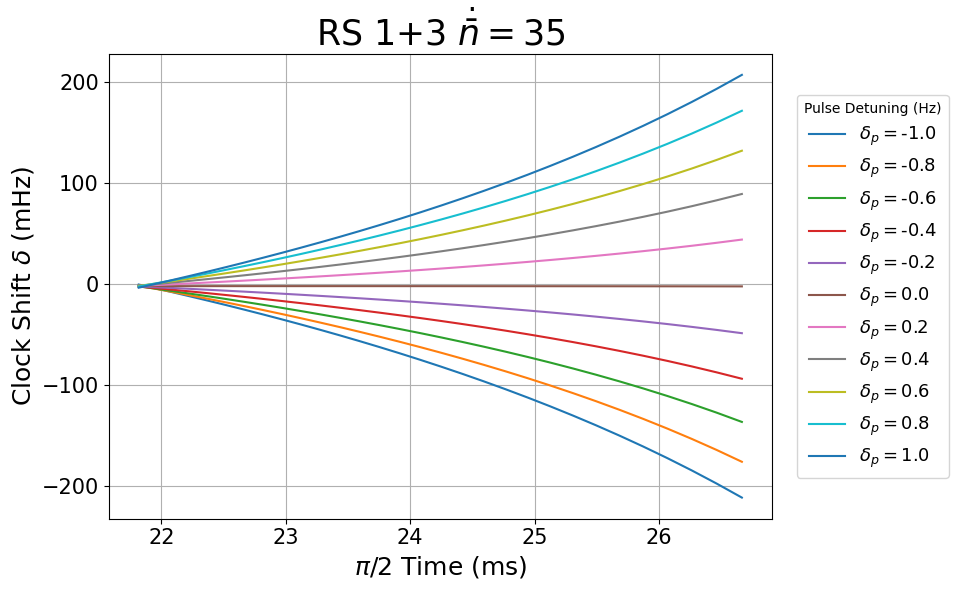

In [10]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(1e3*np.pi/(2.*Omegas), 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title(r"RS 1+3 $\dot{\bar{n}}=35$",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"$\pi/2$ Time (ms)",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
#plt.ylim(-20,20)
plt.show()

In [115]:
nbarfPts = 11
delPrime = -2.0*2.0*np.pi
OmegaPts = 30
Omegas = np.linspace(0.9, 1.1, OmegaPts)*np.pi/(2.*24.0e-3)
results = np.zeros([delPts, OmegaPts])


t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*24.0e-3)
Ncut = 500
nbarfs = np.linspace(0,100, nbarfPts)

for ii in range(nbarfPts):
    results[ii,:] = shiftvOmega(HR, t1, T, t2, delPrime, delPrime, Omegas, nbarfs[ii], Ncut)

-0.7832181091786348
[-5.783218109178635, 4.216781890821365]
-0.7029427302675246
[-5.702942730267525, 4.297057269732475]
-0.6259563993647642
[-5.625956399364764, 4.374043600635236]
-0.5520552517289331
[-5.552055251728933, 4.447944748271067]
-0.48104972299846926
[-5.48104972299847, 4.51895027700153]
-0.4127634599861268
[-5.4127634599861265, 4.5872365400138735]
-0.34703231342171637
[-5.347032313421717, 4.652967686578283]
-0.2837034018526325
[-5.283703401852632, 4.716296598147368]
-0.22263424417465738
[-5.222634244174658, 4.777365755825342]
-0.16369195757642097
[-5.163691957576421, 4.836308042423579]
-0.10675251726764282
[-5.106752517267643, 4.893247482732357]
-0.05170007415075233
[-5.0517000741507525, 4.9482999258492475]
0.0015736734682817886
[-4.998426326531718, 5.001573673468282]
0.05317005799397107
[-4.946829942006029, 5.053170057993971]
0.10318397423227335
[-4.896816025767727, 5.103183974232273]
0.15170436825089556
[-4.848295631749105, 5.151704368250895]
0.19881468681211134
[-4.801185

-0.40133029541500553
[-5.401330295415006, 4.598669704584994]
-0.34568785775298133
[-5.345687857752981, 4.654312142247019]
-0.29184935615346014
[-5.2918493561534605, 4.7081506438465395]
-0.2397257509626924
[-5.239725750962692, 4.760274249037308]
-0.18923374286817887
[-5.189233742868179, 4.810766257131821]
-0.14029542849529705
[-5.140295428495297, 4.859704571504703]
-0.09283798552143604
[-5.092837985521436, 4.907162014478564]
-0.0467933861556578
[-5.046793386155658, 4.953206613844342]
-0.0020981379383497364
[-5.00209813793835, 4.99790186206165]
-2.705832338777861
[-7.705832338777861, 2.294167661222139]
-2.561021844168109
[-7.561021844168109, 2.438978155831891]
-2.422822721237218
[-7.4228227212372175, 2.577177278762782]
-2.290889282011774
[-7.290889282011774, 2.709110717988226]
-2.1648875615960095
[-7.164887561596009, 2.8351124384039905]
-2.0444968603079126
[-7.0444968603079126, 2.9555031396920874]
-1.9294106439583478
[-6.929410643958348, 3.070589356041652]
-1.819337038600767
[-6.81933703

-2.8787132118679875
[-7.8787132118679875, 2.1212867881320125]
-2.7562153468910213
[-7.756215346891022, 2.2437846531089787]
-2.6387628560824092
[-7.638762856082409, 2.3612371439175908]
-2.5261313358821798
[-7.52613133588218, 2.4738686641178202]
-2.4181034510184203
[-7.41810345101842, 2.5818965489815797]
-2.3144696640087092
[-7.314469664008709, 2.6855303359912908]
-2.2150287388853576
[-7.215028738885358, 2.7849712611146424]
-2.119588059675741
[-7.119588059675741, 2.880411940324259]
-2.0279637987726127
[-7.027963798772612, 2.9720362012273873]
-1.9399809653297202
[-6.93998096532972, 3.0600190346702796]
-1.855473359289028
[-6.855473359289028, 3.144526640710972]
-1.7742834526178444
[-6.774283452617844, 3.225716547382156]
-1.6962622158034846
[-6.696262215803484, 3.3037377841965156]
-1.6212689045955273
[-6.621268904595527, 3.378731095404473]
-1.5491708193676677
[-6.549170819367667, 3.4508291806323323]
-1.4798430472498818
[-6.479843047249882, 3.520156952750118]
-1.4131681953143893
[-6.413168195

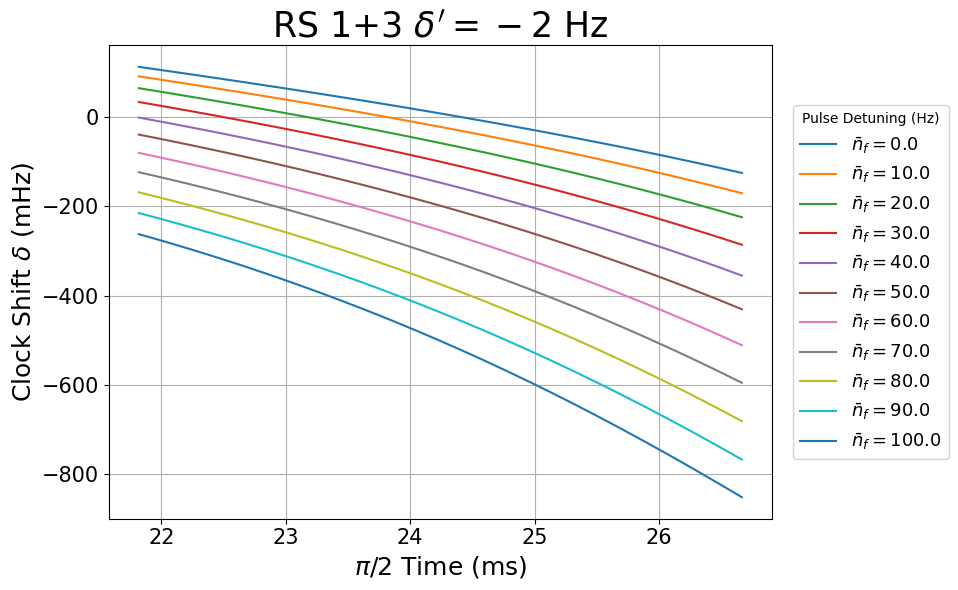

In [118]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(nbarfPts):
    plt.plot(1e3*np.pi/(2.*Omegas), 1e3*results[ii,:]/(2.0*np.pi), label=r"$\bar{n}_f = $" + str(round(nbarfs[ii], 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title(r"RS 1+3 $\delta'= -2$ Hz",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"$\pi/2$ Time (ms)",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
#plt.ylim(-20,20)
plt.show()

In [104]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
OmegaPts = 30
Omegas = np.linspace(0.9, 1.1, OmegaPts)*np.pi/(2.*22.0e-3)
results = np.zeros([delPts, OmegaPts])


t1 = 24e-3
T = 150e-3
t2 = t1
Omega0 = np.pi/(2.*24.0e-3)
Ncut = 300
nbarf = 35

for ii in range(delPts):
    results[ii,:] = shiftvOmega(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omegas, nbarf, Ncut)

1.233597180137472
[-3.766402819862528, 6.2335971801374725]
1.2383029020883793
[-3.761697097911621, 6.238302902088379]
1.2430868774195136
[-3.756913122580486, 6.243086877419514]
1.247950661905433
[-3.752049338094567, 6.247950661905433]
1.2528958565923334
[-3.7471041434076664, 6.252895856592334]
1.2579241095289693
[-3.742075890471031, 6.257924109528969]
1.2630371174670876
[-3.7369628825329126, 6.263037117467087]
1.2682366276373438
[-3.731763372362656, 6.268236627637344]
1.2735244396044656
[-3.726475560395534, 6.273524439604466]
1.2789024072059028
[-3.7210975927940972, 6.278902407205903]
1.284372440578465
[-3.7156275594215353, 6.284372440578465]
1.2899365082774603
[-3.71006349172254, 6.28993650827746]
1.295596639493569
[-3.704403360506431, 6.295596639493569]
1.3013549263724857
[-3.6986450736275143, 6.301354926372486]
1.3072135264431555
[-3.6927864735568443, 6.307213526443156]
1.3131746651605043
[-3.6868253348394955, 6.3131746651605045]
1.3192406385690627
[-3.6807593614309373, 6.3192406385

0.2619239334655493
[-4.73807606653445, 5.26192393346555]
0.26325064936224735
[-4.736749350637752, 5.263250649362248]
0.26460155159438
[-4.73539844840562, 5.26460155159438]
0.26597722262208295
[-4.734022777377917, 5.265977222622083]
0.2673782647318077
[-4.732621735268192, 5.267378264731808]
0.26880530088453414
[-4.731194699115466, 5.268805300884534]
0.2702589756082973
[-4.729741024391703, 5.270258975608297]
0.2717399559378458
[-4.7282600440621545, 5.2717399559378455]
0.27324893240447
[-4.72675106759553, 5.27324893240447]
0.27478662007893234
[-4.725213379921068, 5.274786620078932]
-0.00886202166016751
[-5.008862021660168, 4.991137978339832]
-0.00886577263578055
[-5.00886577263578, 4.99113422736422]
-0.008869493565311968
[-5.008869493565312, 4.991130506434688]
-0.008873258849581152
[-5.008873258849581, 4.991126741150419]
-0.0088770675297519
[-5.008877067529752, 4.991122932470248]
-0.008880920132274577
[-5.008880920132275, 4.991119079867725]
-0.008884817167049598
[-5.00888481716705, 4.9911

-1.066804025362297
[-6.066804025362297, 3.933195974637703]
-1.0716709364488173
[-6.071670936448817, 3.9283290635511827]
-1.0766239184650719
[-6.076623918465072, 3.9233760815349283]
-1.081664938301014
[-6.081664938301014, 3.9183350616989863]
-1.086796026837138
[-6.086796026837138, 3.913203973162862]
-1.0920192815481706
[-6.09201928154817, 3.9079807184518294]
-1.0973368692362617
[-6.097336869236262, 3.902663130763738]
-1.1027510289013103
[-6.10275102890131, 3.8972489710986897]
-1.1082640747564454
[-6.108264074756446, 3.8917359252435544]
-1.113878399397509
[-6.1138783993975085, 3.886121600602491]
-1.1195964771356932
[-6.119596477135693, 3.880403522864307]
-1.125420867503254
[-6.125420867503254, 3.874579132496746]
-1.1313542189431374
[-6.131354218943137, 3.8686457810568626]
-1.137399272693631
[-6.1373992726936315, 3.862600727306369]
-1.143558866880493
[-6.143558866880493, 3.8564411331195068]
-1.251321481032485
[-6.251321481032485, 3.748678518967515]
-1.2560345632738796
[-6.25603456327388, 

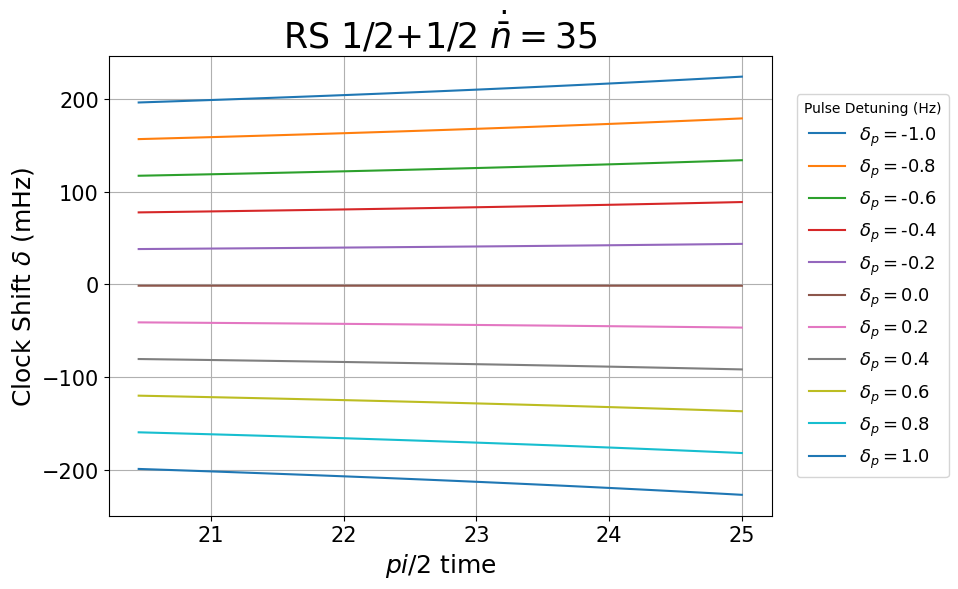

In [106]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(1e3*np.pi/(2.*Omegas), 1e3*results[ii,:]/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title(r"RS 1/2+1/2 $\dot{\bar{n}}=35$",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"$\pi/2$ Time (ms)",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
#plt.ylim(-20,20)
plt.show()

In [15]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results1 = np.zeros([delPts, nbarfPts])
results2 = np.zeros([delPts, nbarfPts])


t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*22.0e-3)
Ncut = 300

for ii in range(delPts):
    results1[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results2[ii,:] = shiftCurve(HR, t2, T, t1, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.30621036470445345
[-4.693789635295547, 5.306210364704453]
0.2945865941918922
[-4.705413405808108, 5.294586594191892]
0.28235648705527744
[-4.717643512944723, 5.282356487055277]
0.26953310757273774
[-4.730466892427263, 5.269533107572737]
0.25612896002883717
[-4.743871039971163, 5.256128960028837]
0.24215595075777446
[-4.757844049242226, 5.242155950757774]
0.2276253635756851
[-4.772374636424315, 5.227625363575685]
0.21254784741575525
[-4.787452152584245, 5.212547847415755]
0.19693341589076394
[-4.803066584109236, 5.196933415890764]
0.1807914645005162
[-4.819208535499484, 5.180791464500516]
0.1641308260602713
[-4.835869173939729, 5.164130826060271]
0.14695990039796775
[-4.853040099602032, 5.146959900397968]
0.1292868911822687
[-4.870713108817731, 5.129286891182269]
0.111120153804916
[-4.888879846195084, 5.111120153804916]
0.09246861921445232
[-4.907531380785548, 5.092468619214452]
0.07334223169782071
[-4.92665776830218, 5.07334223169782]
0.05375233456019598
[-4.946247665439804, 5.053752

-0.003964041230413367
[-5.003964041230414, 4.996035958769586]
-0.01705568347978244
[-5.017055683479782, 4.982944316520218]
-0.0304004615989526
[-5.030400461598953, 4.969599538401047]
-0.04398678028410967
[-5.04398678028411, 4.95601321971589]
-0.05780224086961146
[-5.057802240869611, 4.942197759130389]
-0.07183380533641343
[-5.071833805336413, 4.928166194663587]
-0.08606796850132892
[-5.086067968501329, 4.913932031498671]
-0.10049092750956966
[-5.100490927509569, 4.899509072490431]
-0.11508874088194126
[-5.115088740881942, 4.884911259118058]
-0.12984747215167447
[-5.129847472151674, 4.870152527848326]
-0.14475331539860403
[-5.144753315398604, 4.855246684601396]
-0.15979270171964527
[-5.159792701719645, 4.840207298280355]
0.18141592258296596
[-4.818584077417034, 5.181415922582966]
0.17973914704344202
[-4.820260852956558, 5.179739147043442]
0.1780917829324412
[-4.821908217067559, 5.178091782932441]
0.1764733783681104
[-4.823526621631889, 5.176473378368111]
0.17488348101323903
[-4.82511651

0.0563316463339641
[-4.943668353666036, 5.056331646333964]
0.05552466288825015
[-4.94447533711175, 5.05552466288825]
0.05472650482354764
[-4.945273495176452, 5.054726504823548]
0.05393721795149475
[-4.9460627820485055, 5.0539372179514945]
0.053156840437701115
[-4.946843159562299, 5.053156840437701]
0.052385403420531704
[-4.947614596579468, 5.052385403420532]
0.051622932329369
[-4.948377067670631, 5.051622932329369]
0.05086944969626303
[-4.949130550303737, 5.050869449696263]
0.05012498007697448
[-4.9498750199230255, 5.0501249800769745]
0.04938955693893784
[-4.950610443061062, 5.049389556938938]
0.04866323047457102
[-4.951336769525429, 5.048663230474571]
0.04794607479152085
[-4.952053925208479, 5.047946074791521]
0.04723819301845842
[-4.952761806981542, 5.047238193018458]
0.046539719393585324
[-4.953460280606414, 5.046539719393586]
0.04585081808037176
[-4.954149181919628, 5.045850818080372]
0.045171679042671206
[-4.954828320957329, 5.045171679042671]
0.04450251168831619
[-4.9554974883116

-0.06194789959113187
[-5.061947899591132, 4.938052100408868]
-0.06209768550758526
[-5.062097685507585, 4.937902314492415]
-0.06225039482549924
[-5.062250394825499, 4.937749605174501]
-0.062405578956186
[-5.062405578956186, 4.937594421043814]
-0.06256280048134734
[-5.062562800481348, 4.937437199518652]
-0.06272163686706544
[-5.0627216368670656, 4.9372783631329344]
-0.06288168373220882
[-5.062881683732209, 4.937118316267791]
-0.06304255754842983
[-5.06304255754843, 4.93695744245157]
-0.06320389771769538
[-5.063203897717695, 4.936796102282305]
-0.06336536802607923
[-5.063365368026079, 4.936634631973921]
-0.06352665751030191
[-5.063526657510302, 4.936473342489698]
-0.11968819175062201
[-5.119688191750622, 4.880311808249378]
-0.1158034240193516
[-5.115803424019352, 4.884196575980648]
-0.11169234897177216
[-5.111692348971772, 4.888307651028228]
-0.10735585112685421
[-5.107355851126854, 4.892644148873146]
-0.10279480510609568
[-5.102794805106096, 4.897205194893904]
-0.09801007738323157
[-5.09

-0.15205663748493678
[-5.152056637484937, 4.847943362515063]
-0.13978975277741162
[-5.1397897527774115, 4.8602102472225885]
-0.1271001804630264
[-5.127100180463026, 4.872899819536974]
-0.11399178002027598
[-5.113991780020276, 4.886008219979724]
-0.10046880024756792
[-5.100468800247568, 4.899531199752432]
-0.08653621034804072
[-5.086536210348041, 4.913463789651959]
-0.07220004280764113
[-5.0722000428076415, 4.9277999571923585]
-0.05746769398389046
[-5.057467693983891, 4.942532306016109]
-0.04234814078182249
[-5.042348140781822, 4.957651859218178]
-0.02685205178183036
[-5.02685205178183, 4.97314794821817]
-0.010991790780855472
[-5.010991790780856, 4.989008209219144]
0.005218674680899903
[-4.9947813253191, 5.0052186746809]
0.021763938928524476
[-4.978236061071476, 5.021763938928524]
0.03862737425240104
[-4.9613726257475985, 5.0386273742524015]
0.055791375007305744
[-4.944208624992695, 5.055791375007305]
0.07323761061857367
[-4.926762389381427, 5.073237610618573]
0.09094727271478313
[-4.90

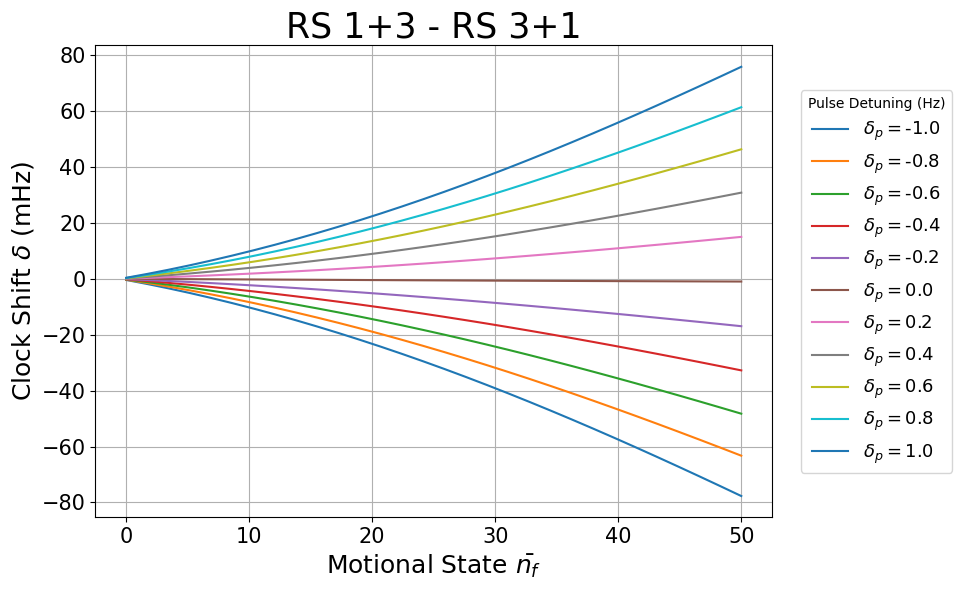

In [16]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*(results1[ii,:]-results2[ii,:])/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 1+3 - RS 3+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [17]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results1 = np.zeros([delPts, nbarfPts])
results2 = np.zeros([delPts, nbarfPts])


t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*24.0e-3)
Ncut = 300

for ii in range(delPts):
    results1[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results2[ii,:] = shiftCurve(HR, t2, T, t1, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

0.013394351678476045
[-4.9866056483215235, 5.0133943516784765]
-0.002935295049486081
[-5.002935295049486, 4.997064704950514]
-0.019964509304497224
[-5.019964509304497, 4.980035490695503]
-0.03769083882025672
[-5.037690838820256, 4.962309161179744]
-0.05611188778394462
[-5.056111887783945, 4.943888112216055]
-0.07522539118689191
[-5.075225391186892, 4.924774608813108]
-0.09502927681106159
[-5.095029276811061, 4.904970723188939]
-0.11552171536924302
[-5.115521715369243, 4.884478284630757]
-0.13670115835754598
[-5.136701158357546, 4.863298841642454]
-0.1585663568145409
[-5.158566356814541, 4.841433643185459]
-0.1811163378957316
[-5.181116337895731, 4.818883662104269]
-0.20435029807907454
[-5.204350298079074, 4.795649701920926]
-0.228267372840528
[-5.228267372840528, 4.771732627159472]
-0.2528662722149904
[-5.25286627221499, 4.74713372778501]
-0.2781448146893512
[-5.278144814689351, 4.721855185310649]
-0.3040994243775004
[-5.3040994243775, 4.6959005756225]
-0.330724665210377
[-5.3307246652

-0.2336083282623436
[-5.233608328262344, 4.766391671737656]
-0.2513138137824341
[-5.251313813782434, 4.748686186217566]
-0.2694405200652343
[-5.269440520065234, 4.730559479934766]
-0.28798107277720386
[-5.287981072777204, 4.712018927222796]
-0.30692669091018526
[-5.306926690910185, 4.693073309089815]
-0.3262673184571984
[-5.326267318457198, 4.673732681542802]
-0.3459917893834525
[-5.3459917893834525, 4.6540082106165475]
-0.3660880102054863
[-5.366088010205487, 4.633911989794513]
-0.3865431473479385
[-5.386543147347939, 4.613456852652061]
-0.40734380958544314
[-5.407343809585443, 4.592656190414557]
-0.4284762188285061
[-5.428476218828506, 4.571523781171494]
-0.4499263650339842
[-5.449926365033984, 4.550073634966016]
-0.47168014303080663
[-5.471680143030807, 4.528319856969193]
0.003384217679600282
[-4.9966157823204, 5.0033842176796]
0.002029654335142428
[-4.997970345664857, 5.002029654335143]
0.0006966277012420096
[-4.999303372298758, 5.000696627701242]
-0.0006151333056088586
[-5.0006151

-0.007319702760373463
[-5.007319702760373, 4.992680297239627]
-0.007986934972019641
[-5.00798693497202, 4.99201306502798]
-0.008646832536471548
[-5.0086468325364715, 4.9913531674635285]
-0.009299344288871374
[-5.009299344288872, 4.990700655711128]
-0.009944404393993333
[-5.009944404393993, 4.990055595606007]
-0.010581925927372277
[-5.010581925927372, 4.989418074072628]
-0.011211796255629
[-5.011211796255629, 4.988788203744371]
-0.011833875056534266
[-5.011833875056534, 4.988166124943466]
-0.012447995227313942
[-5.012447995227314, 4.987552004772686]
-0.013053966410685396
[-5.013053966410685, 4.986946033589315]
-0.013651580530133725
[-5.013651580530134, 4.986348419469866]
-0.014240618581927983
[-5.014240618581928, 4.985759381418072]
-0.01482085794288302
[-5.014820857942883, 4.985179142057117]
-0.015392079561828522
[-5.0153920795618285, 4.9846079204381715]
-0.015954074558154202
[-5.015954074558154, 4.984045925441846]
-0.016506649912825615
[-5.0165066499128255, 4.9834933500871745]
-0.01704

0.018697221494609687
[-4.98130277850539, 5.01869722149461]
0.02539278692555965
[-4.9746072130744405, 5.0253927869255595]
0.032378746616457545
[-4.967621253383543, 5.032378746616457]
0.03965748644843377
[-4.960342513551566, 5.039657486448434]
0.04723137198792483
[-4.952768628012075, 5.047231371987925]
0.055102767671962816
[-4.944897232328037, 5.055102767671963]
0.06327405074066214
[-4.936725949259338, 5.063274050740662]
0.07174760933346741
[-4.9282523906665325, 5.0717476093334675]
0.08052580632609255
[-4.919474193673907, 5.080525806326093]
0.08961089082762161
[-4.910389109172378, 5.089610890827622]
0.09900485193332272
[-4.900995148066677, 5.099004851933323]
0.10870922792123654
[-4.891290772078763, 5.108709227921237]
0.11872489827311584
[-4.881275101726884, 5.118724898273116]
0.12905188994827893
[-4.870948110051721, 5.129051889948279]
0.13968922401105024
[-4.86031077598895, 5.13968922401105]
0.1506348183176681
[-4.849365181682332, 5.150634818317668]
0.1618854509439003
[-4.838114549056099

0.41543132874521227
[-4.584568671254788, 5.415431328745212]
0.4403795803365292
[-4.559620419663471, 5.440379580336529]
0.46579659637088244
[-4.5342034036291174, 5.4657965963708826]
0.49166309128671476
[-4.508336908713285, 5.491663091286715]
0.5179592381146869
[-4.4820407618853135, 5.5179592381146865]
0.5446648885460157
[-4.4553351114539845, 5.5446648885460155]
0.5717597668661663
[-4.428240233133834, 5.571759766866166]
-0.009295967871617487
[-5.009295967871617, 4.990704032128383]
-0.008491518842233025
[-5.008491518842233, 4.991508481157767]
-0.007717384805255476
[-5.007717384805256, 4.992282615194744]
-0.0069725661308550416
[-5.006972566130855, 4.993027433869145]
-0.006256085663090653
[-5.00625608566309, 4.99374391433691]
-0.005566989180641254
[-5.005566989180641, 4.994433010819359]
-0.004904345726345147
[-5.004904345726345, 4.995095654273655]
-0.0042672478188614344
[-5.004267247818861, 4.995732752181139]
-0.003654811561344523
[-5.003654811561344, 4.996345188438656]
-0.00306617667243140

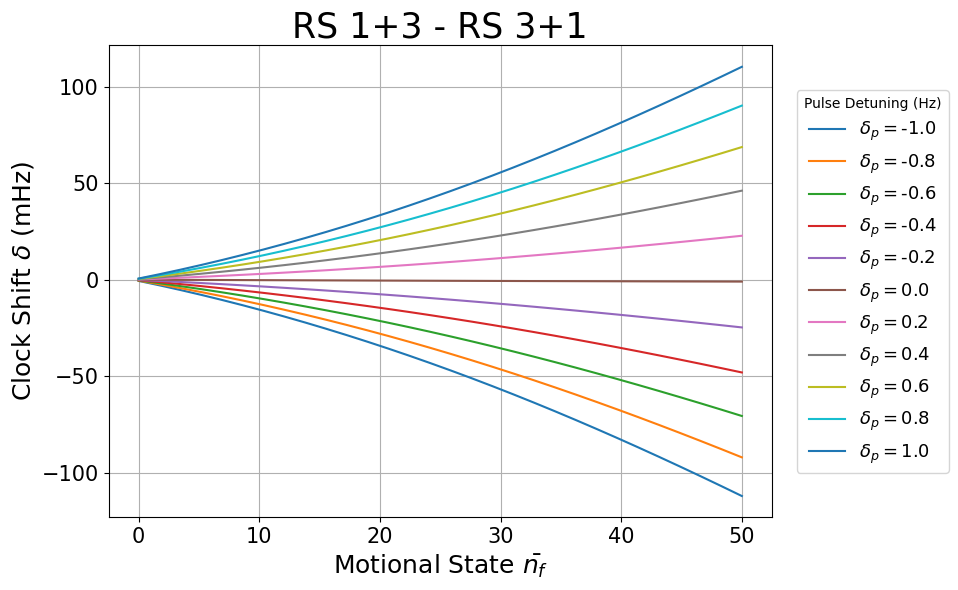

In [18]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*(results1[ii,:]-results2[ii,:])/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 1+3 - RS 3+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [19]:
delPts = 11
delPrimes = 2.0*np.pi*np.linspace(-1,1, delPts)
nbarfPts = 30
nbarfs = np.linspace(0, 50, nbarfPts)
results1 = np.zeros([delPts, nbarfPts])
results2 = np.zeros([delPts, nbarfPts])


t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*26.0e-3)
Ncut = 300

for ii in range(delPts):
    results1[ii,:] = shiftCurve(HR, t1, T, t2, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)
    results2[ii,:] = shiftCurve(HR, t2, T, t1, delPrimes[ii], delPrimes[ii], Omega0, nbarfs, Ncut)

-0.3605307982998028
[-5.360530798299803, 4.639469201700197]
-0.3849193911195074
[-5.3849193911195075, 4.6150806088804925]
-0.4102837631124469
[-5.410283763112447, 4.589716236887553]
-0.436633951737605
[-5.436633951737605, 4.563366048262395]
-0.4639802663758739
[-5.463980266375874, 4.536019733624126]
-0.4923333674983868
[-5.492333367498387, 4.507666632501613]
-0.5217043350771494
[-5.52170433507715, 4.47829566492285]
-0.5521047264417746
[-5.552104726441774, 4.447895273558226]
-0.5835466224603808
[-5.583546622460381, 4.416453377539619]
-0.6160426528278141
[-5.616042652827814, 4.383957347172186]
-0.6496059701656117
[-5.649605970165612, 4.350394029834388]
-0.6842501178914898
[-5.68425011789149, 4.31574988210851]
-0.7199887349062413
[-5.7199887349062415, 4.2800112650937585]
-0.7568350750070126
[-5.756835075007013, 4.243164924992987]
-0.7948013737354426
[-5.794801373735442, 4.205198626264558]
-0.8338981401336931
[-5.833898140133693, 4.166101859866307]
-0.8741334673049437
[-5.874133467304944, 

-0.7981253795311082
[-5.7981253795311085, 4.2018746204688915]
-0.8315414181570431
[-5.831541418157043, 4.168458581842957]
-0.8657653195870396
[-5.865765319587039, 4.134234680412961]
-0.9007909750550884
[-5.900790975055088, 4.099209024944912]
-0.9366115217564821
[-5.9366115217564825, 4.0633884782435175]
-0.9732195100910943
[-5.973219510091094, 4.026780489908906]
-0.2265438868866542
[-5.226543886886654, 4.773456113113346]
-0.2276938694807994
[-5.2276938694808, 4.7723061305192]
-0.22882693187816214
[-5.228826931878162, 4.771173068121838]
-0.2299432526611207
[-5.229943252661121, 4.770056747338879]
-0.231043012841754
[-5.231043012841754, 4.768956987158246]
-0.2321263954382589
[-5.232126395438259, 4.767873604561741]
-0.23319358506348561
[-5.233193585063486, 4.766806414936514]
-0.23424476753659068
[-5.234244767536591, 4.765755232463409]
-0.235280129485318
[-5.235280129485318, 4.764719870514682]
-0.23629985775400011
[-5.236299857754, 4.763700142246]
-0.23730413807508166
[-5.237304138075082, 4.

-0.0851861016713534
[-5.085186101671353, 4.914813898328647]
-0.08579102245859886
[-5.085791022458599, 4.914208977541401]
-0.08638952217911454
[-5.086389522179115, 4.913610477820885]
-0.08698153183476398
[-5.086981531834764, 4.913018468165236]
-0.08756696296414147
[-5.087566962964141, 4.912433037035859]
-0.08814570336897615
[-5.088145703368976, 4.911854296631024]
-0.08871761523011844
[-5.088717615230118, 4.911282384769882]
-0.0892825358544758
[-5.089282535854476, 4.910717464145524]
-0.08984028082072655
[-5.089840280820726, 4.910159719179274]
-0.09039064898068641
[-5.090390648980686, 4.909609351019314]
-0.09093342863737802
[-5.090933428637378, 4.909066571362622]
-0.09146840422624172
[-5.091468404226242, 4.908531595773758]
-0.09199536292146113
[-5.091995362921461, 4.908004637078539]
-0.09251410072815394
[-5.092514100728154, 4.907485899271846]
-0.0930244277671284
[-5.093024427767128, 4.906975572232872]
-0.09352617259128021
[-5.093526172591281, 4.906473827408719]
-0.09401918547963958
[-5.09

0.07150924728050734
[-4.928490752719493, 5.071509247280507]
0.07127337463287207
[-4.928726625367128, 5.071273374632872]
0.07103980002630596
[-4.928960199973694, 5.071039800026306]
0.0708087397112544
[-4.9291912602887455, 5.0708087397112545]
0.15617526077647698
[-4.843824739223523, 5.156175260776477]
0.1654830704229456
[-4.834516929577054, 5.165483070422946]
0.17521340036716818
[-4.824786599632832, 5.175213400367168]
0.18537498440477373
[-4.814625015595226, 5.185374984404774]
0.1959767230756492
[-4.804023276924351, 5.195976723075649]
0.20702772522090612
[-4.7929722747790935, 5.2070277252209065]
0.2185373492219186
[-4.7814626507780815, 5.2185373492219185]
0.23051524361699596
[-4.769484756383004, 5.230515243616996]
0.24297138622691503
[-4.757028613773085, 5.242971386226915]
0.2559161173562633
[-4.744083882643737, 5.255916117356263]
0.26936015323888846
[-4.730639846761112, 5.269360153238888]
0.2833145546754752
[-4.716685445324525, 5.283314554675475]
0.29779062450791066
[-4.70220937549209, 

0.8048297337280192
[-4.1951702662719805, 5.8048297337280195]
0.8411785053375281
[-4.1588214946624715, 5.8411785053375285]
0.8785508878356222
[-4.1214491121643775, 5.8785508878356225]
0.9169419223404985
[-4.083058077659501, 5.916941922340499]
0.9563440790840911
[-4.043655920915909, 5.956344079084091]
0.9967475234440981
[-4.003252476555902, 5.996747523444098]
1.0381404022753782
[-3.961859597724622, 6.038140402275378]
1.0805091327471374
[-3.9194908672528626, 6.080509132747137]
1.1238386806592118
[-3.8761613193407882, 6.123838680659212]
1.1681128194439223
[-3.8318871805560777, 6.168112819443922]
1.2133143645514695
[-3.7866856354485305, 6.2133143645514695]
0.29311703032012687
[-4.7068829696798735, 5.2931170303201265]
0.2936403885795609
[-4.706359611420439, 5.293640388579561]
0.29414151104129377
[-4.7058584889587065, 5.2941415110412935]
0.29462115802640215
[-4.705378841973598, 5.294621158026402]
0.29508007193196883
[-4.704919928068032, 5.295080071931968]
0.2955189770523594
[-4.70448102294764

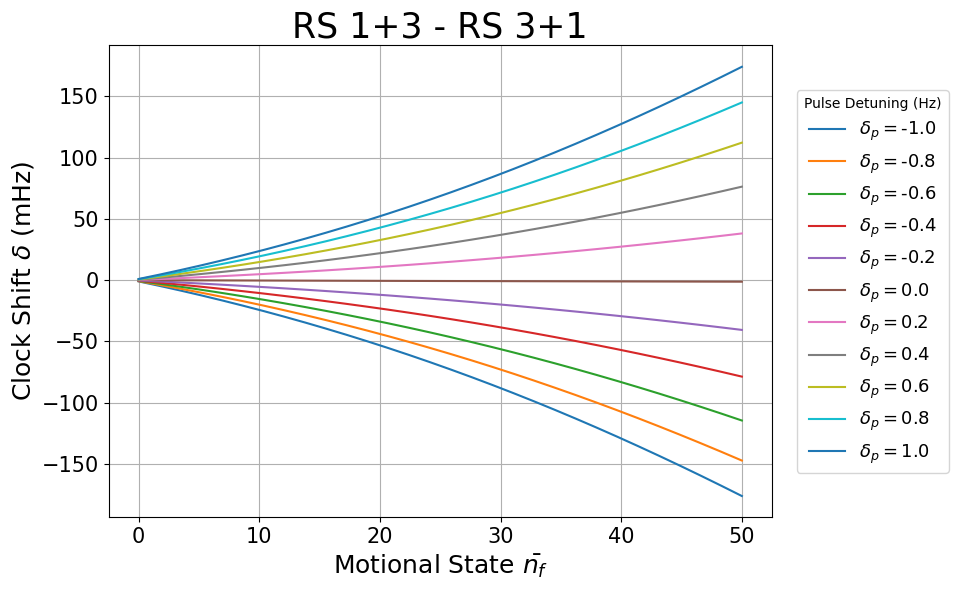

In [20]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delPts):
    plt.plot(nbarfs, 1e3*(results1[ii,:]-results2[ii,:])/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.0*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title("RS 1+3 - RS 3+1",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Motional State $\bar{n_f}$",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
plt.show()

In [21]:
nbarfPts = 11
delPrime = -2.0*2.0*np.pi
OmegaPts = 30
Omegas = np.linspace(0.9, 1.1, OmegaPts)*np.pi/(2.*24.0e-3)
results1 = np.zeros([delPts, OmegaPts])
results2 = np.zeros([delPts, OmegaPts])

t1 = 24e-3
T = 150e-3
t2 = 3.*t1
Omega0 = np.pi/(2.*24.0e-3)
Ncut = 500
nbarfs = np.linspace(0,100, nbarfPts)

for ii in range(nbarfPts):
    results1[ii,:] = shiftvOmega(HR, t1, T, t2, delPrime, delPrime, Omegas, nbarfs[ii], Ncut)
    results2[ii,:] = shiftvOmega(HR, t2, T, t1, delPrime, delPrime, Omegas, nbarfs[ii], Ncut)


-0.7832181091786348
[-5.783218109178635, 4.216781890821365]
-0.7029427302675246
[-5.702942730267525, 4.297057269732475]
-0.6259563993647642
[-5.625956399364764, 4.374043600635236]
-0.5520552517289331
[-5.552055251728933, 4.447944748271067]
-0.48104972299846926
[-5.48104972299847, 4.51895027700153]
-0.4127634599861268
[-5.4127634599861265, 4.5872365400138735]
-0.34703231342171637
[-5.347032313421717, 4.652967686578283]
-0.2837034018526325
[-5.283703401852632, 4.716296598147368]
-0.22263424417465738
[-5.222634244174658, 4.777365755825342]
-0.16369195757642097
[-5.163691957576421, 4.836308042423579]
-0.10675251726764282
[-5.106752517267643, 4.893247482732357]
-0.05170007415075233
[-5.0517000741507525, 4.9482999258492475]
0.0015736734682817886
[-4.998426326531718, 5.001573673468282]
0.05317005799397107
[-4.946829942006029, 5.053170057993971]
0.10318397423227335
[-4.896816025767727, 5.103183974232273]
0.15170436825089556
[-4.848295631749105, 5.151704368250895]
0.19881468681211134
[-4.801185

-0.0808320842275469
[-5.080832084227547, 4.919167915772453]
-0.029383543696412405
[-5.0293835436964125, 4.9706164563035875]
0.020517360697017404
[-4.979482639302983, 5.020517360697017]
0.06895256917415148
[-4.931047430825848, 5.068952569174152]
0.11599896179765365
[-4.884001038202347, 5.115998961797653]
0.1617287010282389
[-4.838271298971761, 5.161728701028239]
0.20620954550570125
[-4.793790454494299, 5.206209545505701]
0.24950513687979917
[-4.750494863120201, 5.249505136879799]
0.2916752613348395
[-4.70832473866516, 5.29167526133484]
0.3327760872610397
[-4.66722391273896, 5.33277608726104]
0.37286038032643326
[-4.627139619673566, 5.372860380326434]
0.41197769699238457
[-4.588022303007615, 5.411977696992385]
-0.7987039209877896
[-5.79870392098779, 4.20129607901221]
-0.7194285386805682
[-5.719428538680568, 4.280571461319432]
-0.6434274809099514
[-5.643427480909951, 4.356572519090049]
-0.5704988566675426
[-5.570498856667543, 4.429501143332457]
-0.5004549723634404
[-5.500454972363441, 4.4

-0.4570877374242943
[-5.4570877374242945, 4.5429122625757055]
-0.39273286812956343
[-5.392732868129563, 4.607267131870437]
-0.330783281830889
[-5.330783281830889, 4.669216718169111]
-0.2710982274617932
[-5.271098227461793, 4.728901772538207]
-0.21354648581467797
[-5.213546485814678, 4.786453514185322]
-0.1580056356274628
[-5.158005635627463, 4.841994364372537]
-0.10436137739790306
[-5.104361377397903, 4.895638622602097]
-0.052506910989555906
[-5.052506910989556, 4.947493089010444]
-0.0023423631477827115
[-5.002342363147783, 4.997657636852217]
0.046225738831849064
[-4.953774261168151, 5.046225738831849]
0.09328495087298413
[-4.9067150491270155, 5.0932849508729845]
0.13891735672083289
[-4.861082643279167, 5.138917356720833]
0.18319997656265913
[-4.816800023437341, 5.183199976562659]
0.22620514263617345
[-4.773794857363827, 5.226205142636173]
0.26800084458144463
[-4.731999155418555, 5.268000844581445]
0.30865104708270624
[-4.691348952917294, 5.308651047082706]
0.34821598214600546
[-4.6517

0.36117054816899535
[-4.638829451831005, 5.361170548168995]
0.39827530613250994
[-4.6017246938674905, 5.3982753061325095]
0.43444622310707326
[-4.565553776892926, 5.434446223107074]
0.46973085392345987
[-4.53026914607654, 5.46973085392346]
0.5041741640005611
[-4.4958258359994385, 5.5041741640005615]
0.5378187086242834
[-4.462181291375717, 5.537818708624283]
0.5707047986070805
[-4.42929520139292, 5.57070479860708]
0.6028706534780194
[-4.3971293465219805, 5.6028706534780195]
-3.7430238471861985
[-8.743023847186198, 1.2569761528138015]
-3.5678781041708354
[-8.567878104170836, 1.4321218958291646]
-3.400265338240078
[-8.400265338240079, 1.5997346617599222]
-3.2399049207139012
[-8.2399049207139, 1.7600950792860988]
-3.086506781778977
[-8.086506781778978, 1.913493218221023]
-2.9397762231819713
[-7.939776223181971, 2.0602237768180287]
-2.7994180315558723
[-7.799418031555872, 2.2005819684441277]
-2.665139782612558
[-7.665139782612558, 2.334860217387442]
-2.5366544410601337
[-7.536654441060134, 

-3.2788057571100895
[-8.278805757110089, 1.7211942428899105]
-3.1397716874215225
[-8.139771687421522, 1.8602283125784775]
-3.006486921399989
[-8.00648692139999, 1.993513078600011]
-2.8787132118679875
[-7.8787132118679875, 2.1212867881320125]
-2.7562153468910213
[-7.756215346891022, 2.2437846531089787]
-2.6387628560824092
[-7.638762856082409, 2.3612371439175908]
-2.5261313358821798
[-7.52613133588218, 2.4738686641178202]
-2.4181034510184203
[-7.41810345101842, 2.5818965489815797]
-2.3144696640087092
[-7.314469664008709, 2.6855303359912908]
-2.2150287388853576
[-7.215028738885358, 2.7849712611146424]
-2.119588059675741
[-7.119588059675741, 2.880411940324259]
-2.0279637987726127
[-7.027963798772612, 2.9720362012273873]
-1.9399809653297202
[-6.93998096532972, 3.0600190346702796]
-1.855473359289028
[-6.855473359289028, 3.144526640710972]
-1.7742834526178444
[-6.774283452617844, 3.225716547382156]
-1.6962622158034846
[-6.696262215803484, 3.3037377841965156]
-1.6212689045955273
[-6.6212689045

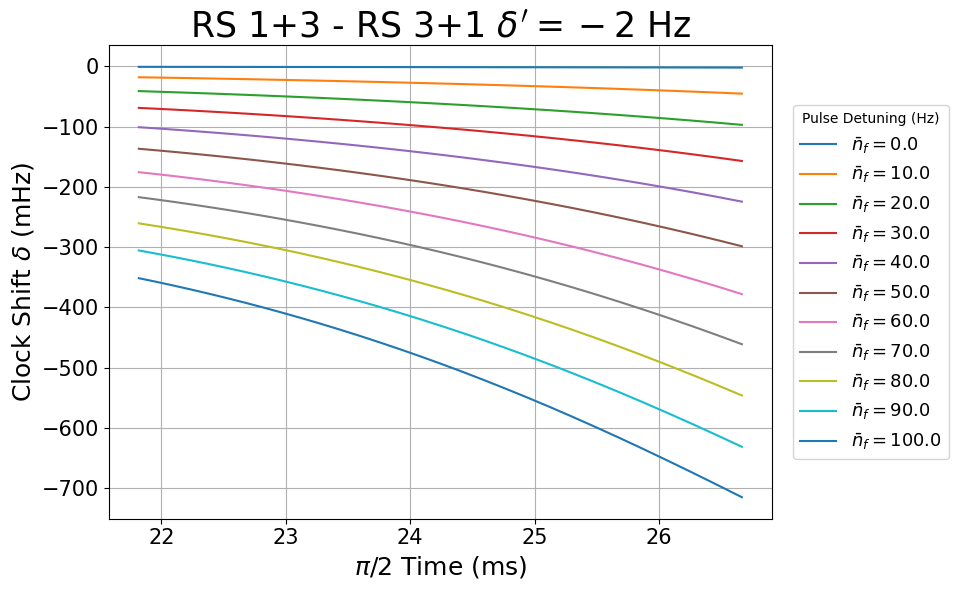

In [22]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(nbarfPts):
    plt.plot(1e3*np.pi/(2.*Omegas), 1e3*(results1[ii,:]-results2[ii,:])/(2.0*np.pi), label=r"$\bar{n}_f = $" + str(round(nbarfs[ii], 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title(r"RS 1+3 - RS 3+1 $\delta'= -2$ Hz",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"$\pi/2$ Time (ms)",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
#plt.ylim(-20,20)
plt.show()

In [41]:
nbarfPts = 11
delPrime = -5.0*2.0*np.pi


OmegaPts = 10
results1 = np.zeros([nbarfPts, OmegaPts])
results2 = np.zeros([nbarfPts, OmegaPts])
t1 = 24.0e-3
T = 150e-3
t2 = 3.*t1
Omegas = np.pi/(2.*np.linspace(22.0e-3,26.0e-3, OmegaPts))
Ncut = 500
nbarfs = np.linspace(50,150, nbarfPts)

for ii in range(nbarfPts):
    results1[ii,:] = shiftvOmega(HR, t2, T, t1, delPrime, delPrime, Omegas, nbarfs[ii], Ncut)

2.1959960476052456
[-2.8040039523947544, 7.195996047605245]
2.0087525849624424
[-2.9912474150375576, 7.008752584962442]
1.8215487023562256
[-3.1784512976437744, 6.821548702356226]
1.633961880120122
[-3.366038119879878, 6.633961880120122]
1.4456517795231962
[-3.554348220476804, 6.445651779523196]
1.256351033328231
[-3.7436489666717687, 6.256351033328231]
1.0658578507237246
[-3.9341421492762754, 6.065857850723725]
0.8740301189760988
[-4.125969881023901, 5.874030118976099]
0.6807805877125153
[-4.3192194122874845, 5.6807805877125155]
0.48607280862309055
[-4.51392719137691, 5.48607280862309]
2.167651900376918
[-2.832348099623082, 7.167651900376918]
1.9820191703817165
[-3.0179808296182835, 6.982019170381717]
1.7962750328784787
[-3.2037249671215213, 6.796275032878478]
1.6100157669321777
[-3.389984233067822, 6.610015766932178]
1.422916957993963
[-3.577083042006037, 6.422916957993963]
1.2347248064652696
[-3.7652751935347304, 6.23472480646527]
1.0452491409476208
[-3.954750859052379, 6.0452491409

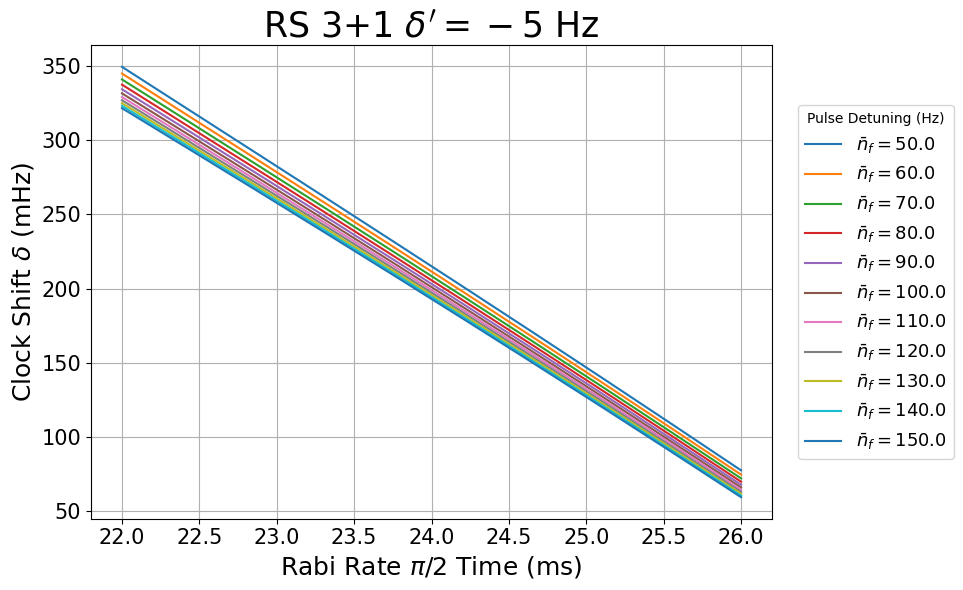

In [43]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(nbarfPts):
    plt.plot(1e3*np.pi/(2*Omegas), 1e3*(results1[ii,:])/(2.0*np.pi), label=r"$\bar{n}_f = $" + str(round(nbarfs[ii], 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title(r"RS 3+1 $\delta'= -5$ Hz",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Rabi Rate $\pi/2$ Time (ms)",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
#plt.ylim(-20,20)
plt.show()

In [48]:
delpts = 11
delPrimes = 2.0*np.pi*np.linspace(-5.0, 5.0, delpts)
nbarf = 75.

OmegaPts = 10
results1 = np.zeros([nbarfPts, OmegaPts])
results2 = np.zeros([nbarfPts, OmegaPts])
t1 = 26.0e-3
T = 150e-3
t2 = 3.*t1
Omegas = np.pi/(2.*np.linspace(24.0e-3,28.0e-3, OmegaPts))
Ncut = 500
#nbarfs = np.linspace(0,100, nbarfPts)

for ii in range(nbarfPts):
    results1[ii,:] = shiftvOmega(HR, t2, T, t1, delPrimes[ii], delPrimes[ii], Omegas, nbarf, Ncut)

2.3775064375403283
[-2.6224935624596717, 7.377506437540328]
2.204226863610239
[-2.795773136389761, 7.20422686361024]
2.0313496581692596
[-2.9686503418307404, 7.03134965816926]
1.858596058896103
[-3.141403941103897, 6.858596058896103]
1.685743827864044
[-3.314256172135956, 6.685743827864044]
1.512620982374927
[-3.4873790176250727, 6.512620982374927]
1.3391005019710596
[-3.6608994980289404, 6.33910050197106]
1.1650959020369716
[-3.8349040979630287, 6.165095902036971]
0.9905574532725299
[-4.00944254672747, 5.99055745327253]
0.8154688742160686
[-4.1845311257839315, 5.8154688742160685]
1.6200317973675855
[-3.3799682026324147, 6.620031797367585]
1.458837380240944
[-3.541162619759056, 6.458837380240944]
1.296129514321977
[-3.703870485678023, 6.2961295143219775]
1.131591491736083
[-3.868408508263917, 6.131591491736083]
0.9649535832544694
[-4.035046416745531, 5.964953583254469]
0.7959892955287979
[-4.204010704471202, 5.795989295528798]
0.6245128185762864
[-4.375487181423714, 5.624512818576286]


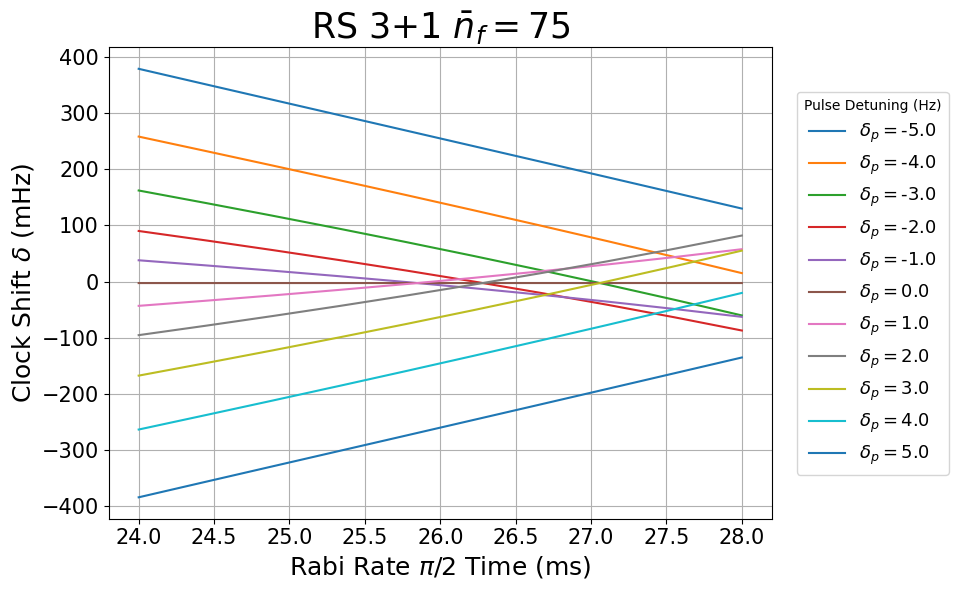

In [50]:
plt.figure(figsize=(10,6), dpi=100)
for ii in range(delpts):
    plt.plot(1e3*np.pi/(2*Omegas), 1e3*(results1[ii,:])/(2.0*np.pi), label=r"$\delta_p = $" + str(round(delPrimes[ii]/(2.*np.pi), 2)))#, color=cm(1+np.abs(ii-delPts//2)))
plt.title(r"RS 3+1 $\bar{n}_f= 75$",fontsize="25")
plt.ylabel(r"Clock Shift $\delta$ (mHz)",fontsize="18")
plt.xlabel(r"Rabi Rate $\pi/2$ Time (ms)",fontsize="18")
plt.grid()
plt.xticks(fontsize="15")
plt.yticks(fontsize="15")
plt.legend(bbox_to_anchor = (1.28,0.5), loc='center right', fontsize="13", title=r"Pulse Detuning (Hz)")
plt.tight_layout()
#plt.ylim(-20,20)
plt.savefig('RabiRateMeasurement.pdf')
plt.show()

In [33]:
50e-3/e3

7.786688383943548e-17